## Name - Vijit Laxman Chekkala (x18199429)


## National College of Ireland

## Supervisor: Dr Vladimir Milosavljevic

## Importing Libraries


In [3]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import xgboost as xgb
import os
from imblearn.over_sampling import SMOTE

In [4]:
dir_path = '/Users/vijitchekkala/Desktop/Hydraulics/Data/data'

In [5]:
def get_files(dir_path, filename):
    return pd.read_csv(os.path.join(dir_path, filename), sep='\t', header=None)

Import all pressure sensors data

In [6]:
pressureFile1 = get_files(dir_path=dir_path, filename='PS1.txt')
pressureFile2 = get_files(dir_path=dir_path, filename='PS2.txt')
pressureFile3 = get_files(dir_path=dir_path, filename='PS3.txt')
pressureFile4 = get_files(dir_path=dir_path, filename='PS4.txt')
pressureFile5 = get_files(dir_path=dir_path, filename='PS5.txt')
pressureFile6 = get_files(dir_path=dir_path, filename='PS6.txt')

Import volume flow files

In [7]:
volumeFlow1 = get_files(dir_path=dir_path, filename='FS1.txt')
volumeFlow2 = get_files(dir_path=dir_path, filename='FS2.txt')

Import temperature files

In [8]:
temperature1 = get_files(dir_path=dir_path, filename='TS1.txt')
temperature2 = get_files(dir_path=dir_path, filename='TS2.txt')
temperature3 = get_files(dir_path=dir_path, filename='TS3.txt')
temperature4 = get_files(dir_path=dir_path, filename='TS4.txt')

Import rest of the data files: pump efficiency, vibrations, cooling efficiency, coolin power, efficiency factor

In [9]:
pump1 = get_files(dir_path=dir_path, filename='EPS1.txt')
vibration1 = get_files(dir_path=dir_path, filename='VS1.txt')
coolingE1 = get_files(dir_path=dir_path, filename='CE.txt')
coolingP1 = get_files(dir_path=dir_path, filename='CP.txt')
effFactor1 = get_files(dir_path=dir_path, filename='SE.txt')

Import Label data from profile file

In [10]:
profile = get_files(dir_path=dir_path, filename='profile.txt')


Split the profile into relevent target labels

In [11]:
y_coolerCondition = pd.DataFrame(profile.iloc[:, 0])
y_valveCondition = pd.DataFrame(profile.iloc[:, 1])
y_pumpLeak = pd.DataFrame(profile.iloc[:, 2])
y_hydraulicAcc = pd.DataFrame(profile.iloc[:, 3])
y_stableFlag = pd.DataFrame(profile.iloc[:, 4])

Assigning Column Names for target variables

In [12]:
y_coolerCondition.columns = ['Coolers']
y_valveCondition.columns = ['Valves']
y_pumpLeak.columns = ['Pump_Leakage']
y_hydraulicAcc.columns = ['Accumulator']
y_stableFlag.columns = ['Stable']


Combine all dataframes

In [13]:
Y = pd.concat([y_coolerCondition,y_valveCondition,y_pumpLeak,y_hydraulicAcc,y_stableFlag], axis=1)

In [14]:
Y.shape #checking the shape of the target variables data frame

(2205, 5)

Average the cycle data of the independent variables

In [15]:
def mean_conversion(df):
    df1 = pd.DataFrame()
    df1 = df.mean(axis = 1)
    return df1

Applying the conversion function to the independent variables

In [16]:

PS1 = pd.DataFrame(mean_conversion(pressureFile1))
PS1.columns = ['PS1']

PS2 = pd.DataFrame(mean_conversion(pressureFile2))
PS2.columns = ['PS2']

PS3 = pd.DataFrame(mean_conversion(pressureFile3))
PS3.columns = ['PS3']

PS4 = pd.DataFrame(mean_conversion(pressureFile4))
PS4.columns = ['PS4']

PS5 = pd.DataFrame(mean_conversion(pressureFile5))
PS5.columns = ['PS5']

PS6 = pd.DataFrame(mean_conversion(pressureFile6))
PS6.columns = ['PS6']

FS1 = pd.DataFrame(mean_conversion(volumeFlow1))
FS1.columns = ['FS1']

FS2 = pd.DataFrame(mean_conversion(volumeFlow2))
FS2.columns = ['FS2']

TS1 = pd.DataFrame(mean_conversion(temperature1))
TS1.columns = ['TS1']

TS2 = pd.DataFrame(mean_conversion(temperature2))
TS2.columns = ['TS2']

TS3 = pd.DataFrame(mean_conversion(temperature3))
TS3.columns = ['TS3']

TS4 = pd.DataFrame(mean_conversion(temperature4))
TS4.columns = ['TS4']

P1 = pd.DataFrame(mean_conversion(pump1))
P1.columns = ['P1']

VS1 = pd.DataFrame(mean_conversion(vibration1))
VS1.columns = ['VS1']

CE1 = pd.DataFrame(mean_conversion(coolingE1))
CE1.columns = ['CE1']

CP1 = pd.DataFrame(mean_conversion(coolingP1))
CP1.columns = ['CP1']

SE1 = pd.DataFrame(mean_conversion(effFactor1))
SE1.columns = ['SE1']

Combine all dataframes

In [17]:
X = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1], axis=1)

In [18]:
X.head(5) #checking the top 5 rows of the indepndent variables

PS1         PS2       PS3  PS4       PS5       PS6       FS1  \
0  160.673492  109.466914  1.991475  0.0  9.842170  9.728097  6.709815   
1  160.603320  109.354890  1.976234  0.0  9.635142  9.529488  6.715315   
2  160.347720  109.158845  1.972224  0.0  9.530548  9.427949  6.718522   
3  160.188088  109.064807  1.946575  0.0  9.438827  9.337430  6.720565   
4  160.000472  108.931434  1.922707  0.0  9.358762  9.260636  6.690308   

         FS2        TS1        TS2        TS3        TS4           P1  \
0  10.304592  35.621983  40.978767  38.471017  31.745250  2538.929167   
1  10.403098  36.676967  41.532767  38.978967  34.493867  2531.498900   
2  10.366250  37.880800  42.442450  39.631950  35.646150  2519.928000   
3  10.302678  38.879050  43.403983  40.403383  36.579467  2511.541633   
4  10.237750  39.803917  44.332750  41.310550  37.427900  2503.449500   

        VS1        CE1       CP1        SE1  
0  0.576950  39.601350  1.862750  59.157183  
1  0.565850  25.786433  1.255550  59.335617  
2  0.576533  22.218233  1.113217  59.543150  
3  0.569267  20.459817  1.062150  59.794900  
4  0.577367  19.787017  1.070467  59.455267

## Independent Variables

Histogram to show frequencies of independent variables

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/vijitchekk

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe769b45550>,
      dtype=object)

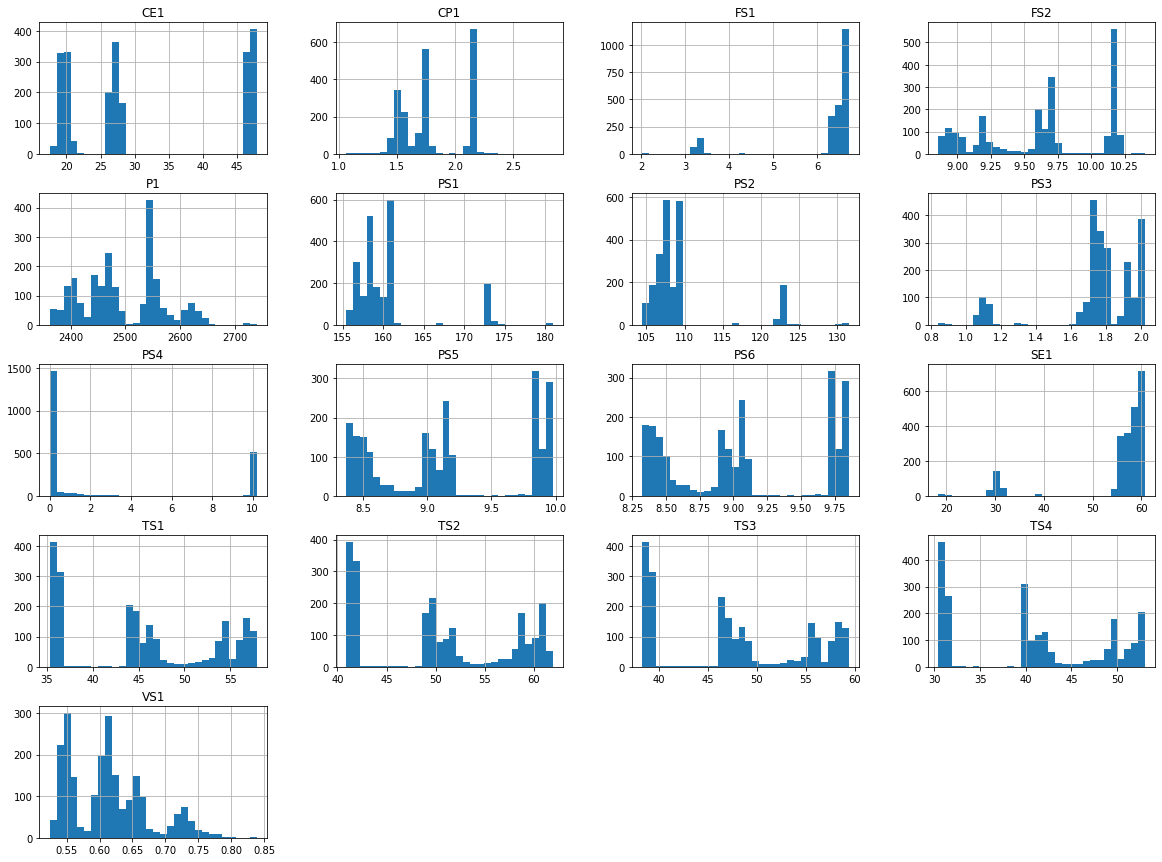

In [19]:
X.hist(bins=30, figsize=(20, 15))

Dealing with outliers in the independent variables

In [20]:
#Scaling data using ROBUST SCALAR to handle outliers
from sklearn.preprocessing import RobustScaler
from pandas import DataFrame
trans = RobustScaler()
X_robust = trans.fit_transform(X)
# convert the array back to a dataframe
X_robust = DataFrame(X_robust)

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/vijitchekk

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe707aa2e10>,
      dtype=object)

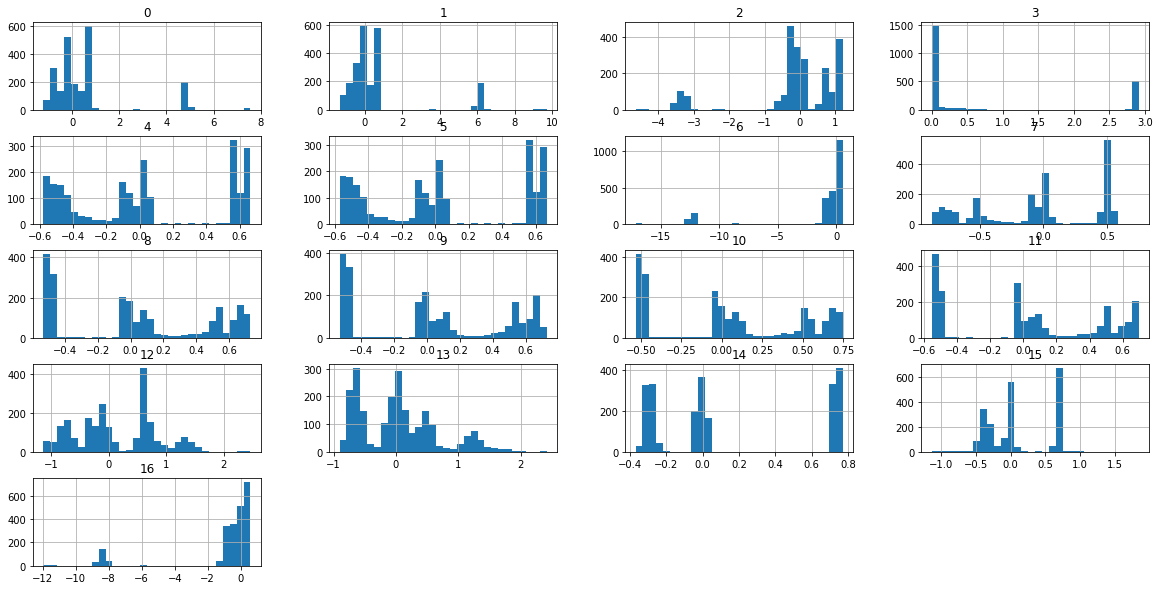

In [21]:
X_robust.hist(bins=30, figsize=(20, 10))

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/vijitchekk

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7088a2c10>,
      dtype=object)

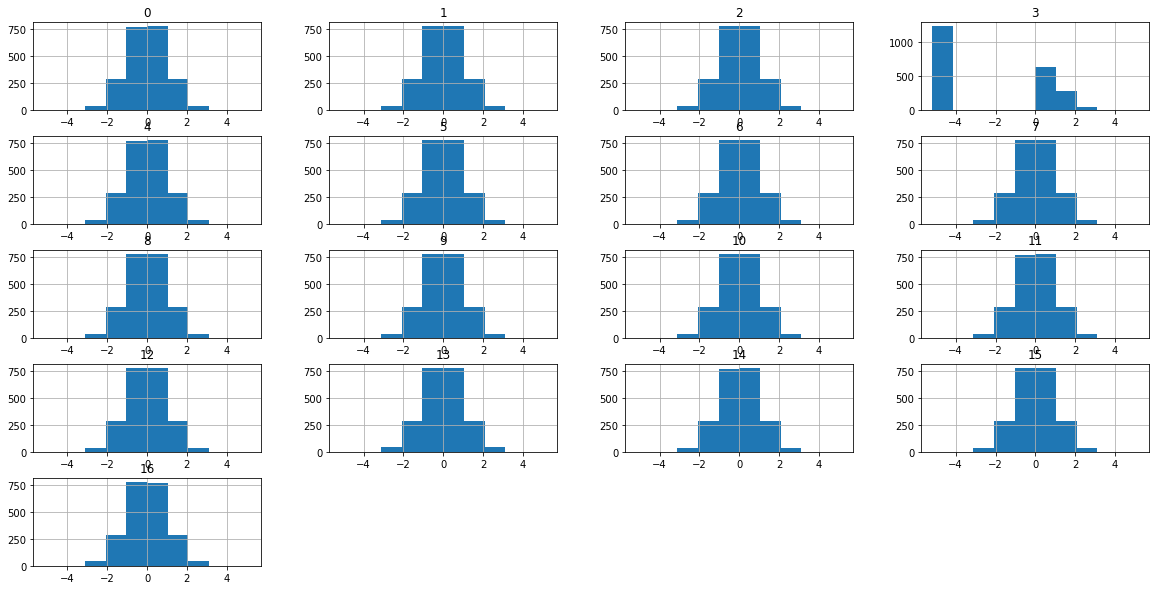

In [22]:

from sklearn.preprocessing import QuantileTransformer
quantile = QuantileTransformer(output_distribution='normal')
data_trans = quantile.fit_transform(X)
X_scaled = DataFrame(data_trans)
X_scaled.hist(figsize=(20,10))

In [23]:
a=PS1=X['PS1']
b=PS1_scaled = X_scaled[0]

In [24]:
os.getcwd()

'/Users/vijitchekkala'

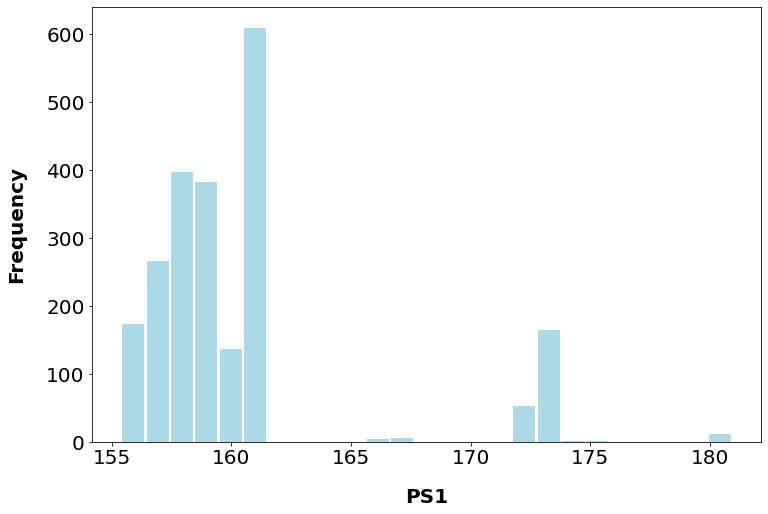

In [25]:
ax = a.hist(bins=25, grid=False, figsize=(12,8), color='lightblue', zorder=2, rwidth=0.9)
# Set x-axis label
ax.set_xlabel("PS1", labelpad=20, weight='bold', size=20)
# Set y-axis label
ax.set_ylabel("Frequency", labelpad=20, weight='bold', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/vijitchekkala/Desktop/RIC_DIAGRAMS/Random_Distributed.png')

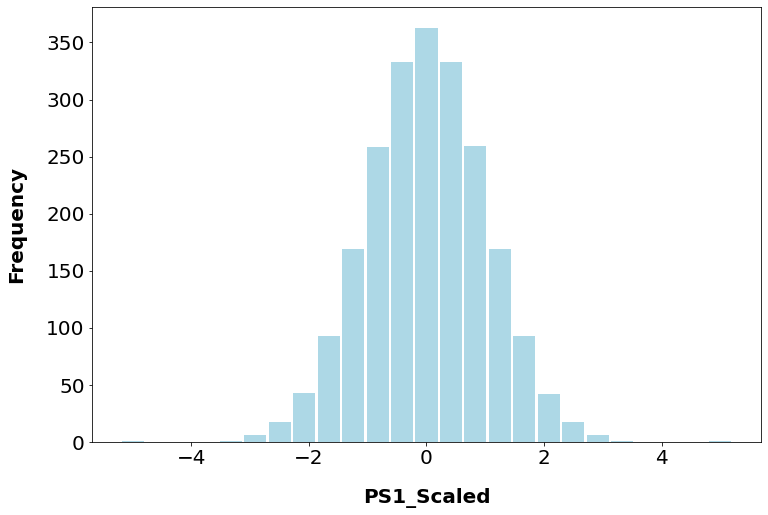

In [26]:
ax = b.hist(bins=25, grid=False, figsize=(12,8), color='lightblue', zorder=2, rwidth=0.9)
# Set x-axis label
ax.set_xlabel("PS1_Scaled", labelpad=20, weight='bold', size=20)
# Set y-axis label
ax.set_ylabel("Frequency", labelpad=20, weight='bold', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/vijitchekkala/Desktop/RIC_DIAGRAMS/Gaussian_Distributed.png')

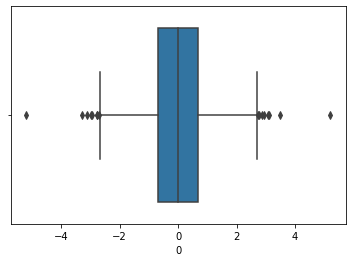

In [27]:
sns.boxplot(x=X_scaled[0])

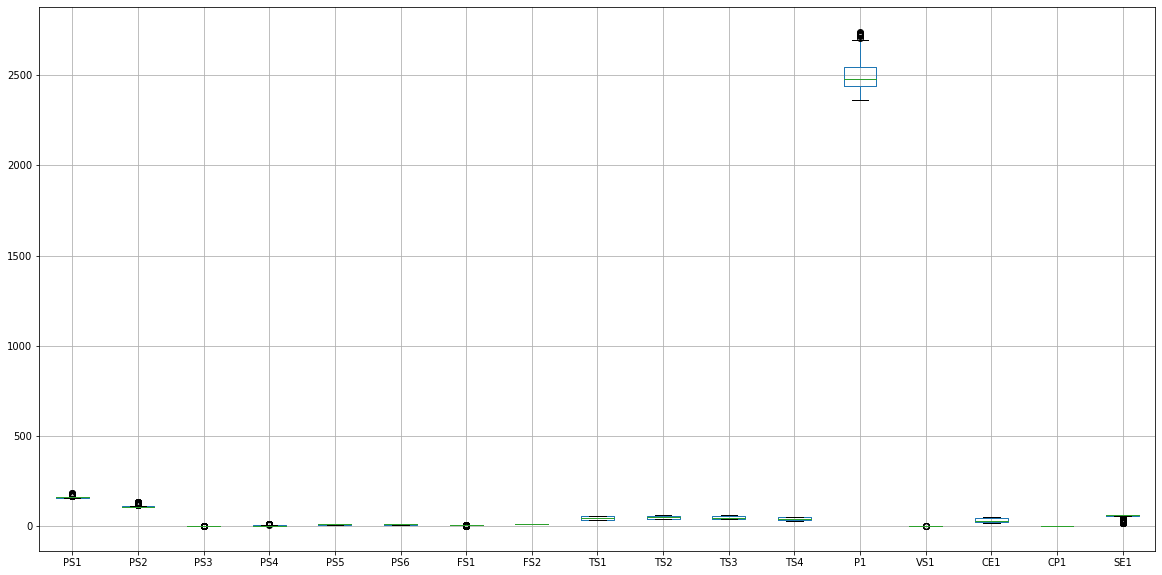

In [28]:
X.boxplot(figsize=(20,10)) #original data

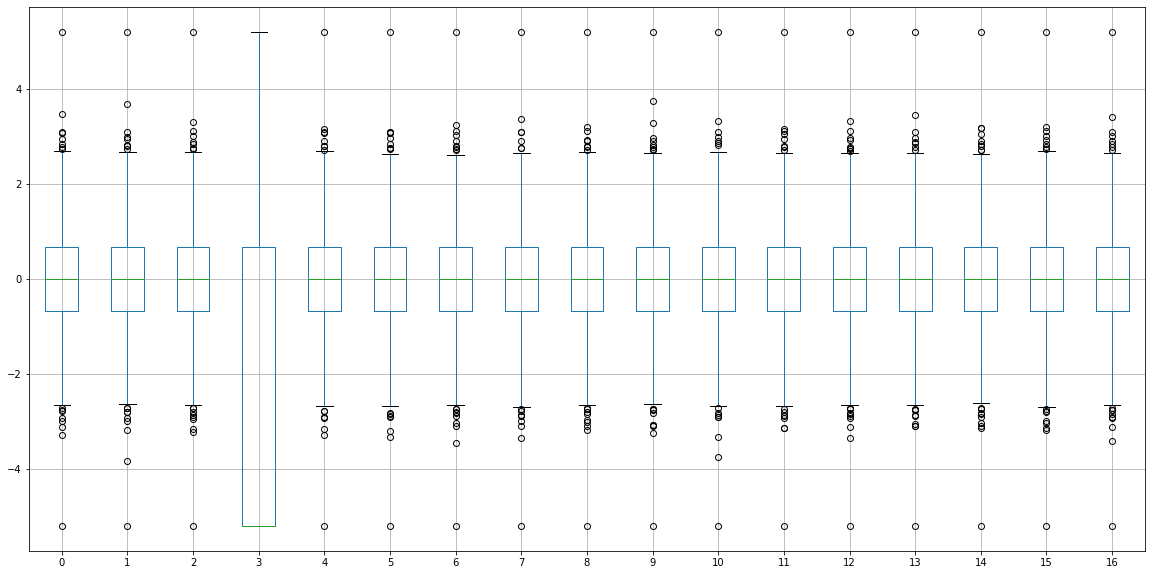

In [29]:
X_scaled.boxplot(figsize=(20, 10)) #quantile transform 

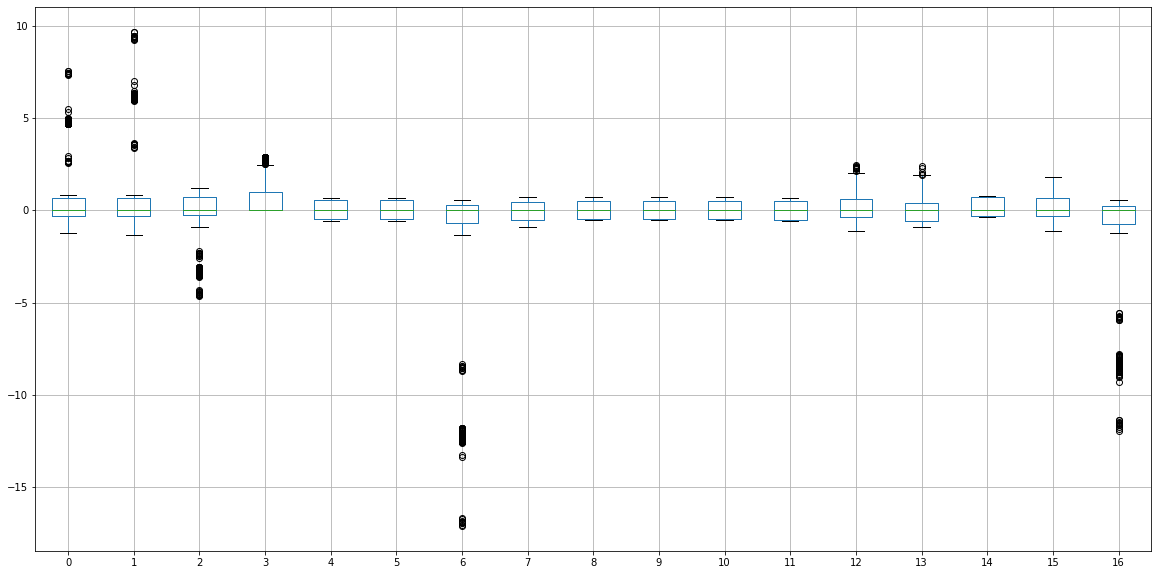

In [30]:
X_robust.boxplot(figsize=(20,10)) #robust scalar


In [31]:
#not remvoing outliers because distant data points are responsible for prediction failure conditions

## Dependent variables - Data transformation

In [32]:
#Y['Valves'].replace(80, 73,inplace=True)

In [33]:
Y['Valves'].value_counts()

100    1125
73      360
90      360
80      360
Name: Valves, dtype: int64

In [34]:
Y['Accumulator'].value_counts()

90     808
130    599
115    399
100    399
Name: Accumulator, dtype: int64

In [35]:
#Y['Accumulator'].replace(100,90,inplace=True)

In [36]:
Y['Accumulator'].value_counts()

90     808
130    599
115    399
100    399
Name: Accumulator, dtype: int64

Visualize target variables

In [37]:
y1 = Y['Coolers']

In [38]:
y2 =Y['Valves']

In [39]:
y3 = Y['Pump_Leakage']

In [40]:
y4 = Y['Accumulator']

In [41]:
y5 = Y['Stable']

In [42]:
# Plot according to the color of safety = https://www.safetyandhealthmagazine.com/articles/the-color-of-safety-2

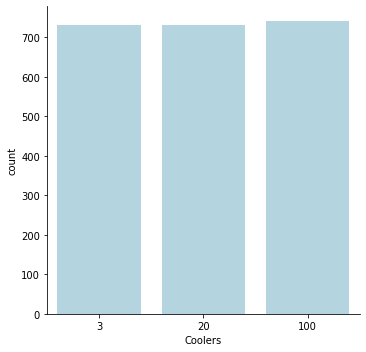

In [43]:
sns.catplot(x="Coolers", kind="count", color='lightblue', data=Y);

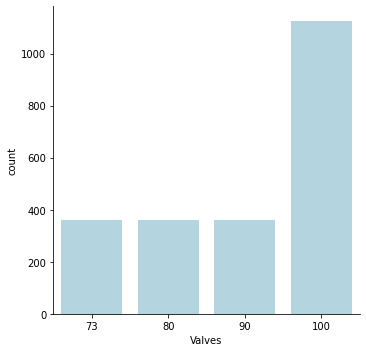

In [44]:
sns.catplot(x="Valves", kind="count", color='lightblue',data=Y);

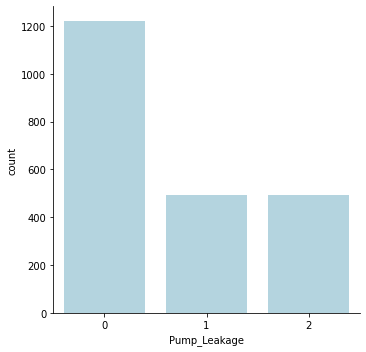

In [45]:
sns.catplot(x="Pump_Leakage", kind="count", color='lightblue', data=Y);

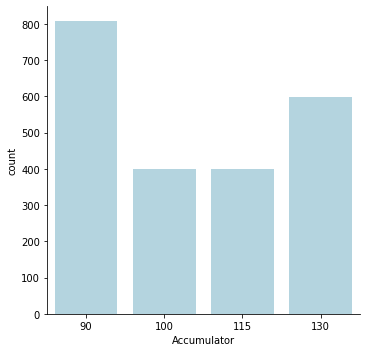

In [46]:
sns.catplot(x="Accumulator", kind="count", color='lightblue', data=Y);

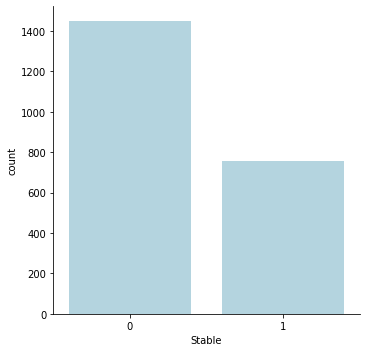

In [47]:
sns.catplot(x="Stable", kind="count", color='lightblue', data=Y);

## Principal Component Analysis

Covariance matrix of features

In [48]:

#features are columns from x_std
features = X_scaled.T
covariance_matrix = np.cov(features)
print(covariance_matrix)

[[ 1.01831979  0.97082946  0.17177197  1.51378423  0.26778756  0.26822494
  -0.04943346  0.25437453 -0.29828224 -0.37561459 -0.27341947 -0.2828352
   0.90900265 -0.13397214  0.31374663  0.33694092 -0.58117672]
 [ 0.97082946  1.02088638  0.17935172  1.48168753  0.26559755  0.26572533
  -0.02476597  0.2472607  -0.29690061 -0.38103735 -0.27105612 -0.27794868
   0.90018796 -0.14359409  0.2934884   0.31483783 -0.53080651]
 [ 0.17177197  0.17935172  1.01771834  1.72827086  0.87485414  0.87458282
   0.80787891  0.83384601 -0.87385708 -0.84202546 -0.87823808 -0.87779508
   0.06167983 -0.82400946  0.76057093  0.76148006  0.27940487]
 [ 1.51378423  1.48168753  1.72827086  9.32088067  1.80267429  1.79806301
   0.68263461  1.75631926 -1.80661011 -1.8659844  -1.79974125 -1.8119683
   1.55941515 -1.72325075  1.87696043  1.90462267 -0.90210618]
 [ 0.26778756  0.26559755  0.87485414  1.80267429  1.01702593  1.01483491
   0.57712325  0.94974298 -1.00234652 -0.98480295 -1.00494499 -1.00203262
   0.26733

Eigen vectors and Eigen values from Covaraince matrix

In [49]:
eig_vals, eig_vecs = np.linalg.eig(covariance_matrix) #linear algebra functions)
print('\n Eigenvectors \n%s' %eig_vecs)


 Eigenvectors 
[[ 1.23268867e-01  2.48003597e-01 -3.79260910e-01 -3.89781183e-01
   4.83869242e-02  2.30301284e-02  4.20841706e-02  4.33027945e-02
   1.58252833e-01 -2.65247374e-01  6.99383154e-01 -9.15734708e-02
  -1.88480489e-02 -1.66140187e-01  4.70243303e-03  7.30199747e-03
  -7.55218573e-03]
 [ 1.21408400e-01  2.40058629e-01 -3.74369976e-01 -4.41328713e-01
   2.21483700e-02 -5.06510401e-02 -1.49613447e-01 -1.28721684e-01
  -1.01700203e-01  2.49285006e-01 -3.59400241e-01  5.82429201e-01
  -7.84355483e-02 -5.15352418e-02 -9.12054362e-04  1.96393993e-02
  -2.50120635e-02]
 [ 1.98657979e-01 -2.26826918e-01  4.30714033e-02 -2.02608304e-01
   7.56300895e-02 -1.65054144e-01  5.09490326e-01 -6.65043192e-02
  -7.16632609e-01 -2.26317644e-01  4.29053955e-03 -7.59931767e-03
  -6.13159959e-02  3.96619204e-03  2.66118030e-03  7.29049468e-03
   2.27934837e-02]
 [ 6.77643244e-01  4.89713048e-01  5.38581671e-01 -6.54538124e-03
  -8.75445593e-02  3.38846950e-02 -3.56096574e-02  1.43121155e-02
   

In [50]:
print('\n Eigenvalues \n%s' %eig_vals)


 Eigenvalues 
[1.64501320e+01 4.75469577e+00 2.14350408e+00 9.05906161e-01
 5.67112705e-01 2.80096412e-01 1.41871825e-01 1.10771012e-01
 6.20126535e-02 4.98341144e-02 4.54836386e-02 3.44310737e-02
 3.17615212e-02 1.51880101e-02 2.48554591e-03 6.36783407e-03
 8.62584028e-03]


In [51]:
#we reduce dimension to 1 dimensin, since 1 eigen vectos has enough variance 
eig_vals[0]/sum(eig_vals)

0.6423253427157957

In [52]:
# for selecting PCA2

In [53]:
eig_vals[1]/sum(eig_vals)

0.18565574952007965

In [54]:
#project data points onto selected eigen vectos

In [55]:
projected_X_1 = data_trans.dot(eig_vecs.T[0])

projected_X_2 = data_trans.dot(eig_vecs.T[1])

In [56]:
projected_X_1

array([-0.51727183, -1.56018171, -2.25026577, ...,  6.69613898,
        7.48794038,  8.32365439])

In [57]:
projected_X_2

array([-5.30769498, -4.85704267, -4.47517591, ..., -2.6227051 ,
       -3.09779308, -3.57361064])

In [58]:
result = pd.DataFrame(projected_X_1)

In [59]:
result['PC2'] = pd.DataFrame(projected_X_2)

In [60]:
result['y-axis']=0.0

In [61]:
result['label']= Y['Coolers']

In [62]:
result = result.drop('label',axis=1)

In [63]:
result = result.rename(columns={0:'PC1'})

In [64]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)

In [65]:
%time pca_1= pca.fit_transform(data_trans)

CPU times: user 23.8 ms, sys: 8.22 ms, total: 32 ms
Wall time: 16.8 ms


In [66]:
pca_1

array([[ 1.1929082 , -4.07181819],
       [ 0.14999832, -3.62116587],
       [-0.54008574, -3.23929912],
       ...,
       [ 8.40631901, -1.38682831],
       [ 9.19812041, -1.86191628],
       [10.03383442, -2.33773384]])

In [67]:
pca_final = result

In [68]:
pca_final.head(2)

PC1       PC2  y-axis
0 -0.517272 -5.307695     0.0
1 -1.560182 -4.857043     0.0

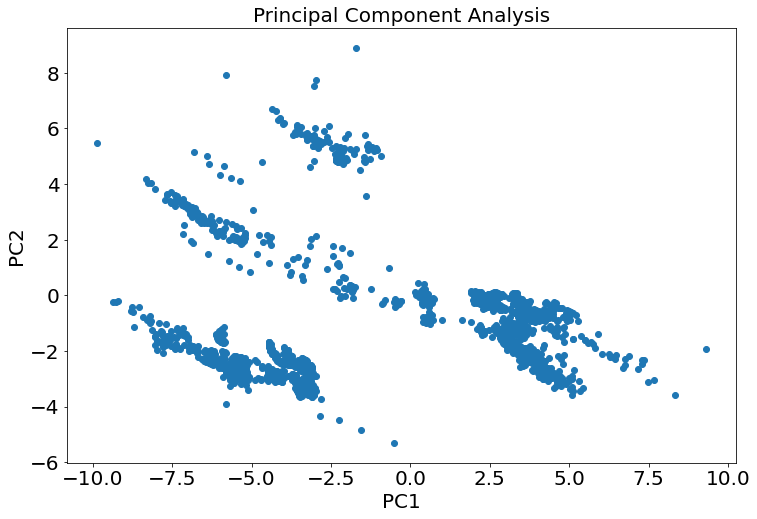

In [69]:
plt.figure(figsize=(12,8))
x='PC1'; y = 'PC2'
plt.scatter(x,y,data=pca_final)
plt.title("Principal Component Analysis", size = 20)
plt.xlabel("PC1",size=20)
plt.xticks(fontsize=20)
plt.ylabel("PC2",size=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/vijitchekkala/Desktop/RIC_DIAGRAMS/PCA.png')

Text(0.5, 1.0, 'PCA results')

<Figure size 1440x720 with 0 Axes>

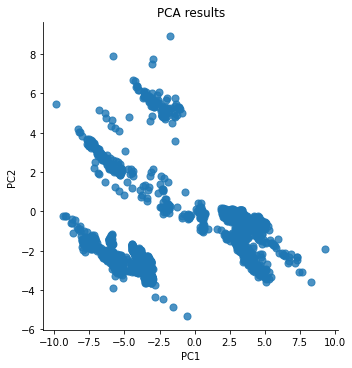

In [70]:
plt.figure(figsize=(20,10))
sns.lmplot('PC1','PC2',data = pca_final, fit_reg=False,
          scatter_kws={"s":50})
plt.title("PCA results")

#plt.savefig('/Users/vijitchekkala/Desktop/pca.png')




## t-distributed stochastic neighbor embedding

In [71]:
from sklearn.manifold import TSNE


In [72]:
data_1 = data_trans[0:2205,:] #using the array instead of dataframe to implement t-sne

In [73]:
labels_1= Y['Coolers']

In [74]:
mod_tsne = TSNE(n_components = 2, random_state=0)

In [75]:
%time tsne_data=mod_tsne.fit_transform(data_1)

CPU times: user 42.8 s, sys: 285 ms, total: 43.1 s
Wall time: 11.8 s


Creating a new data frame which help us in plotting the result data

In [76]:
tsne_data=np.vstack((tsne_data.T,labels_1)).T

In [77]:
tsne_df=pd.DataFrame(data=tsne_data,columns=['Dim_1','Dim_2','Label'])

In [78]:
label = Y['Coolers']

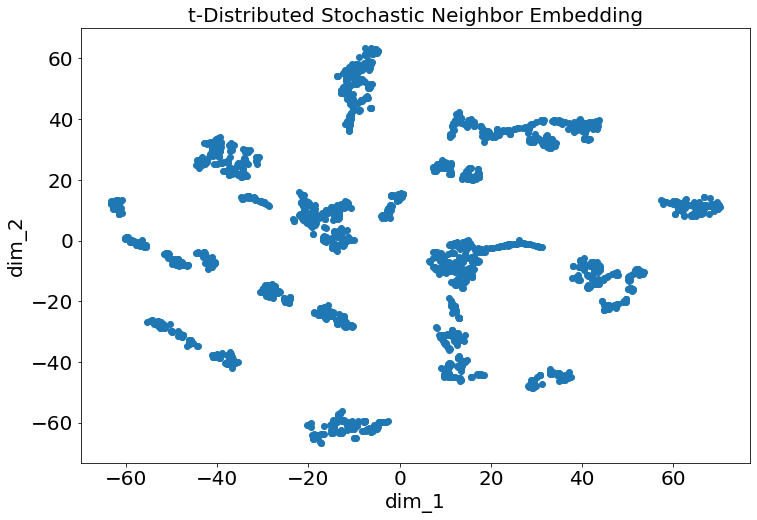

In [79]:
plt.figure(figsize=(12,8))
x='Dim_1'; y = 'Dim_2'
plt.scatter(x,y,data=tsne_df)
plt.title("t-Distributed Stochastic Neighbor Embedding", size = 20)
plt.xlabel("dim_1",size=20)
plt.xticks(fontsize=20)
plt.ylabel("dim_2",size=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/vijitchekkala/Desktop/RIC_DIAGRAMS/t-SNE.png')

## UMAP

In [80]:
import umap
from umap import UMAP
fit = umap.UMAP(n_neighbors=200, min_dist=0.0, n_components=2)


In [81]:
%time u = fit.fit_transform(data_trans)

CPU times: user 20.6 s, sys: 192 ms, total: 20.7 s
Wall time: 12.9 s


In [82]:
u

array([[ 2.6807063, -6.5185995],
       [ 2.6199   , -6.7609434],
       [ 2.6342103, -6.8446045],
       ...,
       [16.855274 ,  9.968491 ],
       [16.856762 ,  9.956568 ],
       [16.865921 ,  9.941453 ]], dtype=float32)

In [83]:
umap_data = pd.DataFrame({'Dim_1': u[:, 0], 'Dim_2': u[:, 1]})

In [84]:
umap_data

Dim_1     Dim_2
0      2.680706 -6.518600
1      2.619900 -6.760943
2      2.634210 -6.844604
3      2.710771 -6.891930
4      2.690090 -6.784121
...         ...       ...
2200  16.867111  9.969485
2201  16.858709  9.964652
2202  16.855274  9.968491
2203  16.856762  9.956568
2204  16.865921  9.941453

[2205 rows x 2 columns]

In [85]:
umap_data.to_csv(r'/Users/vijitchekkala/Desktop/umap_data.csv', index = False)

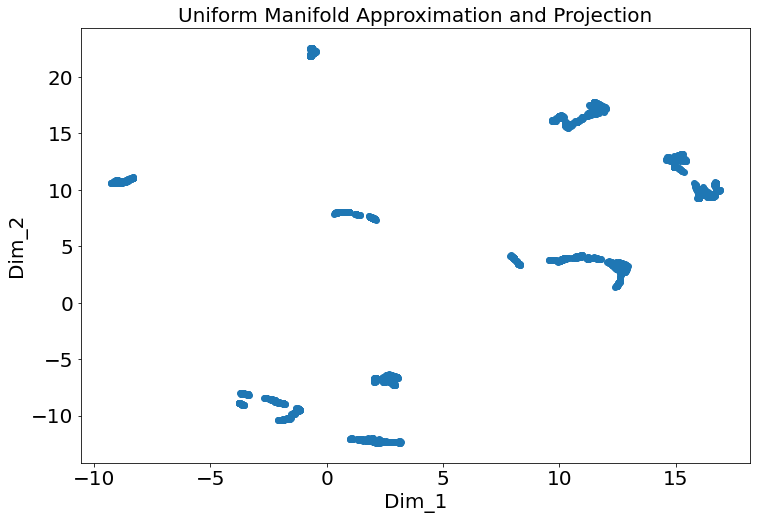

In [86]:
plt.figure(figsize=(12,8))
x='Dim_1'; y = 'Dim_2'
plt.scatter(x,y,data=umap_data)
plt.title("Uniform Manifold Approximation and Projection", size = 20)
plt.xlabel("Dim_1",size=20)
plt.xticks(fontsize=20)
plt.ylabel("Dim_2",size=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/vijitchekkala/Desktop/RIC_DIAGRAMS/UMAP.png')

## Coolers


In [87]:
X

PS1         PS2       PS3        PS4       PS5       PS6  \
0     160.673492  109.466914  1.991475   0.000000  9.842170  9.728097   
1     160.603320  109.354890  1.976234   0.000000  9.635142  9.529488   
2     160.347720  109.158845  1.972224   0.000000  9.530548  9.427949   
3     160.188088  109.064807  1.946575   0.000000  9.438827  9.337430   
4     160.000472  108.931434  1.922707   0.000000  9.358762  9.260636   
...          ...         ...       ...        ...       ...       ...   
2200  161.227572  109.779581  2.001438  10.202473  9.972037  9.850361   
2201  161.206070  109.787481  1.998781  10.197919  9.966184  9.844854   
2202  161.192120  109.756174  1.993436  10.196824  9.964329  9.842628   
2203  161.208917  109.793884  2.007077  10.198588  9.968232  9.846690   
2204  161.217128  109.792177  2.002690  10.203126  9.973638  9.851949   

           FS1        FS2        TS1        TS2        TS3        TS4  \
0     6.709815  10.304592  35.621983  40.978767  38.471017  31.745250   
1     6.715315  10.403098  36.676967  41.532767  38.978967  34.493867   
2     6.718522  10.366250  37.880800  42.442450  39.631950  35.646150   
3     6.720565  10.302678  38.879050  43.403983  40.403383  36.579467   
4     6.690308  10.237750  39.803917  44.332750  41.310550  37.427900   
...        ...        ...        ...        ...        ...        ...   
2200  6.689930  10.184515  35.313783  40.874800  38.269267  30.404733   
2201  6.692182  10.177767  35.321600  40.868883  38.268250  30.416233   
2202  6.693277  10.176172  35.319183  40.875950  38.246367  30.426250   
2203  6.684128  10.178353  35.324767  40.876067  38.245733  30.414283   
2204  6.692302  10.183393  35.322233  40.859400  38.248917  30.390800   

               P1       VS1        CE1       CP1        SE1  
0     2538.929167  0.576950  39.601350  1.862750  59.157183  
1     2531.498900  0.565850  25.786433  1.255550  59.335617  
2     2519.928000  0.576533  22.218233  1.113217  59.543150  
3     2511.541633  0.569267  20.459817  1.062150  59.794900  
4     2503.449500  0.577367  19.787017  1.070467  59.455267  
...           ...       ...        ...       ...        ...  
2200  2543.911033  0.550833  46.628517  2.160600  59.033100  
2201  2543.411333  0.547483  46.689817  2.151450  59.068000  
2202  2542.729767  0.545233  46.472300  2.143300  59.132350  
2203  2544.046333  0.537017  46.544967  2.148483  58.970800  
2204  2543.818300  0.546583  46.647933  2.157050  59.053900  

[2205 rows x 17 columns]

In [88]:
cooler_1 = pd.concat([y2,y3,y4],axis=1)

In [89]:
Z= pd.concat([y_coolerCondition,y_valveCondition,y_pumpLeak,y_hydraulicAcc,y_stableFlag],axis=1)

In [90]:
z2 = Z['Valves']

In [91]:
z2.value_counts()

100    1125
73      360
90      360
80      360
Name: Valves, dtype: int64

In [92]:
z4 = Z['Accumulator']

In [93]:
#umap_cooler.to_csv(r'/Users/vijitchekkala/Desktop/Hydraulics/Data/umap_cooler.csv') #deleted

In [94]:
from sklearn.linear_model import LogisticRegression

In [95]:
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(umap_data, y1, test_size=0.4)



# Hyperparamter tuning using RandomisedSearchCV

In [96]:
logModel_CLR = LogisticRegression()
params_CLR = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [97]:
from sklearn.model_selection import RandomizedSearchCV

## Logistic Regression for Cooler condition

In [98]:
clf_CLR = RandomizedSearchCV(logModel_CLR, param_distributions = params_CLR, cv = 10, verbose=3)


In [99]:
best_clf_CLR = clf_CLR.fit(umap_data,y1)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..
[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=0.955, total=   0.1s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..
[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=0.968, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..
[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=0.968, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..
[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=1.000, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-p

[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=1.000, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..
[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=0.991, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..
[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=0.968, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..
[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=0.927, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..
[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=0.936, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607 ..


/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packag

[CV]  solver=lbfgs, penalty=none, max_iter=5000, C=78.47599703514607, score=0.927, total=   0.0s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 
[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=0.955, total=   0.2s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=0.968, total=   0.2s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 
[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=0.968, total=   0.1s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/v

[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=1.000, total=   0.2s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 
[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=1.000, total=   0.1s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=0.991, total=   0.2s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 
[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=0.968, total=   0.1s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 
[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=0.927, total=   0.1s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=0.936, total=   0.2s
[CV] solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026 
[CV]  solver=newton-cg, penalty=l2, max_iter=1000, C=0.615848211066026, score=0.927, total=   0.1s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479 .....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479, score=0.955, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479 .....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479, score=0.968, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479 .....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479, score=0.968, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479 .....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479, score=1.000, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=206.913808111479 .....


/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=0.955, total=   0.1s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 
[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=0.968, total=   0.2s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search faile

[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=0.968, total=   0.3s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 
[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=1.000, total=   0.2s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search faile

[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=1.000, total=   0.1s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 
[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=0.991, total=   0.2s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=0.968, total=   0.1s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search faile

[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=0.927, total=   0.3s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 
[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=0.936, total=   0.2s
[CV] solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, s

[CV]  solver=newton-cg, penalty=none, max_iter=5000, C=0.08858667904100823, score=0.927, total=   0.1s
[CV] solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752 ...
[CV]  solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752 ...
[CV]  solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752 ...
[CV]  solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752 ...
[CV]  solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752 ...
[CV]  solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=5000, C=0.004832930238571752 ...
[

/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=0.968, total=   0.1s
[CV] solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search faile

[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=0.968, total=   0.3s
[CV] solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752 
[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=1.000, total=   0.2s
[CV] solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=1.000, total=   0.1s
[CV] solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search faile

[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=0.991, total=   0.2s
[CV] solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752 
[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=0.968, total=   0.1s
[CV] solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=0.927, total=   0.3s
[CV] solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752 


/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search faile

[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=0.936, total=   0.2s
[CV] solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752 
[CV]  solver=newton-cg, penalty=none, max_iter=100, C=0.004832930238571752, score=0.927, total=   0.2s
[CV] solver=liblinear, penalty=l1, max_iter=5000, C=0.08858667904100823 
[CV]  solver=liblinear, penalty=l1, max_iter=5000, C=0.08858667904100823, score=0.955, total=   0.0s
[CV] solver=liblinear, penalty=l1, max_iter=5000, C=0.08858667904100823 
[CV]  solver=liblinear, penalty=l1, max_iter=5000, C=0.08858667904100823, score=0.968, total=   0.0s
[CV] solver=liblinear, penalty=l1, max_iter=5000, C=0.08858667904100823 
[CV]  solver=liblinear, penalty=l1, max_iter=5000, C=0.08858667904100823, score=0.968, total=   0.0s
[CV] solver=liblinear, penalty=l1, max_iter=5000, C=0.08858667904100823 
[CV]  solver=liblinear, penalty=l1, max_iter=5000, C=0.08858667904100823, score=1.000, total=   0.0s
[CV] solver=liblinear, 

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721, score=0.968, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721, score=1.000, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721, score=1.000, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721, score=0.991, total=   0.1s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721, score=0.968, total=   0.1s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721, score=0.927, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=1.623776739188721 ....
[CV]

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.8s finished
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [100]:
best_clf_CLR.best_estimator_

LogisticRegression(C=78.47599703514607, max_iter=5000, penalty='none')

In [101]:
print (f'Accuracy - : {best_clf_CLR.score(umap_data,y1):.4f}')

Accuracy - : 0.9642


In [348]:
classifier_logistic = LogisticRegression(C=78.47599703514607, max_iter=5000, penalty='none')
#values from Randomised Search CV
classifier_logistic.fit(X_train_C, y_train_C)

y_pred_CLR = classifier_logistic.predict(X_test_C)

from sklearn.metrics import confusion_matrix 
cm_CLR = confusion_matrix(y_test_C, y_pred_CLR) 
  
print ("Confusion Matrix : \n", cm_CLR) 
print(classification_report(y_test_C, y_pred_CLR))

Confusion Matrix : 
 [[298   2   0]
 [ 31 262   0]
 [  0   0 289]]
              precision    recall  f1-score   support

           3       0.91      0.99      0.95       300
          20       0.99      0.89      0.94       293
         100       1.00      1.00      1.00       289

    accuracy                           0.96       882
   macro avg       0.97      0.96      0.96       882
weighted avg       0.97      0.96      0.96       882



/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


 ## XGBOOST for Cooler condition

## Bayesian optimisation

In [103]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

space = {
  "objective":['binary','multiclass'],
  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
  "min_child_weight" : [ 1, 3, 5, 7 ],
  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [104]:

def objective(space):
    model = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=7, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
    
    accuracy = cross_val_score(model, X_train_C, y_train_C, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

from sklearn.model_selection import cross_val_score
get_ipython().run_line_magic('time', '')
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
100%|██████████| 80/80 [00:26<00:00,  3.01trial/s, best loss: -0.994702687249857]


{}

## RandomisedSearchCV for XGboost - Coolers

In [105]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [106]:
## Hyper Parameter Optimization

params_CXGB={
  "objective":['binary','multiclass'],
  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [107]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost


In [108]:
classifier_CXGB = xgboost.XGBClassifier()

In [109]:
random_search_CXGB=RandomizedSearchCV(classifier_CXGB,param_distributions=params_CXGB,n_iter=5,cv=10)

In [110]:
random_search_CXGB.fit(umap_data,y1)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [111]:
random_search_CXGB.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [112]:
print (f'Accuracy - : {random_search_CXGB.score(umap_data,y1):.3f}')

Accuracy - : 0.997


In [350]:
xgb_CXGB = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=12,
              min_child_weight=7, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [351]:
xgb_CXGB.fit(X_train_C, y_train_C)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [352]:
y_pred_CXGB = xgb_CXGB.predict(X_test_C)

from sklearn.metrics import confusion_matrix 
cm_CXGB = confusion_matrix(y_test_C, y_pred_CXGB) 
  
print ("Confusion Matrix : \n", cm_CXGB) 
print(classification_report(y_test_C, y_pred_CXGB))

Confusion Matrix : 
 [[298   2   0]
 [  1 292   0]
 [  0   0 289]]
              precision    recall  f1-score   support

           3       1.00      0.99      0.99       300
          20       0.99      1.00      0.99       293
         100       1.00      1.00      1.00       289

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882



## LightGBM for Cooler condition

In [116]:
import lightgbm as lgb

In [117]:
Params_lgb = {
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt','dart','goss'],
    'max_depth' : [5,6,7,8], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01,0.02,0.03,0.04,0.05],
    'min_data_in_leaf':[2,4,6,8,10],
    'objective': ['binary','multiclass'], 
    'num_class':[1,2,3,4,5], 
    'metric': ['multi_logloss','roc','auc'] 
    }

In [118]:
#modelling
clf_CLGB = lgb.LGBMClassifier()


In [119]:
random_search_LGB = RandomizedSearchCV(clf_CLGB,param_distributions=Params_lgb,cv = 10)

In [120]:
random_search_LGB.fit(umap_data,y1)

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgb

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [5, 6, 7, 8],
                                        'metric': ['multi_logloss', 'roc',
                                                   'auc'],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'min_split_gain': [0.01, 0.02, 0.03,
                                                           0.04, 0.05],
                                        'num_class': [1, 2, 3, 4, 5],
                                        'num_leaves': [90, 200],
                    

In [121]:
random_search_LGB.best_estimator_

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.15, max_depth=7,
               metric='multi_logloss', min_data_in_leaf=10, min_split_gain=0.02,
               num_class=1, num_leaves=90, objective='multiclass',
               subsample=0.5)

In [122]:
print (f'Accuracy - : {random_search_LGB.score(umap_data,y1):.3f}')

Accuracy - : 1.000


In [353]:
lgb_CLGB = lgb.LGBMClassifier(colsample_bytree=0.5, learning_rate=0.15, max_depth=7,
               metric='multi_logloss', min_data_in_leaf=10, min_split_gain=0.02,
               num_class=1, num_leaves=90, objective='multiclass',
               subsample=0.5)

In [354]:
lgb_CLGB.fit(X_train_C, y_train_C)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.15, max_depth=7,
               metric='multi_logloss', min_data_in_leaf=10, min_split_gain=0.02,
               num_class=1, num_leaves=90, objective='multiclass',
               subsample=0.5)

In [355]:
y_pred_CLGB = lgb_CLGB.predict(X_test_C)

from sklearn.metrics import confusion_matrix 
cm_CLGB = confusion_matrix(y_test_C, y_pred_CLGB) 
  
print ("Confusion Matrix : \n", cm_CLGB) 
print(classification_report(y_test_C, y_pred_CLGB))

Confusion Matrix : 
 [[298   2   0]
 [  0 293   0]
 [  0   0 289]]
              precision    recall  f1-score   support

           3       1.00      0.99      1.00       300
          20       0.99      1.00      1.00       293
         100       1.00      1.00      1.00       289

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882



## Catboost for Cooler condition

In [126]:
from catboost import CatBoostClassifier


In [127]:
params_cat = {
    'grow_policy': ['Lossguide'],
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     'bootstrap_type' :['Bayesian', 'Bernoulli', 'MVS', 'Poisson'],
    'depth' : [5,6,7,8],
    'min_data_in_leaf':[2,4,6,8,10],
    'num_leaves': [90,200]
    }



In [128]:
clf_cat = CatBoostClassifier(iterations=200)

In [129]:
random_search_cat = RandomizedSearchCV(clf_cat,param_distributions=params_cat,cv = 10)

In [130]:
random_search_cat.fit(umap_data,y1)

0:	learn: 1.0054606	total: 67.5ms	remaining: 13.4s


/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1731, in _fit
    save_snapshot, snapshot_file, snapshot_interval, init_model
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1659, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx",

1:	learn: 0.9260932	total: 82ms	remaining: 8.12s
2:	learn: 0.8549138	total: 88.5ms	remaining: 5.81s
3:	learn: 0.7922672	total: 96.2ms	remaining: 4.71s
4:	learn: 0.7367884	total: 104ms	remaining: 4.08s
5:	learn: 0.6864248	total: 111ms	remaining: 3.6s
6:	learn: 0.6409822	total: 120ms	remaining: 3.3s
7:	learn: 0.5996665	total: 129ms	remaining: 3.09s
8:	learn: 0.5619381	total: 136ms	remaining: 2.9s
9:	learn: 0.5271618	total: 144ms	remaining: 2.73s
10:	learn: 0.4954870	total: 151ms	remaining: 2.6s
11:	learn: 0.4660235	total: 164ms	remaining: 2.56s
12:	learn: 0.4389562	total: 172ms	remaining: 2.48s
13:	learn: 0.4139046	total: 180ms	remaining: 2.39s
14:	learn: 0.3900654	total: 187ms	remaining: 2.31s
15:	learn: 0.3682883	total: 196ms	remaining: 2.25s
16:	learn: 0.3482816	total: 204ms	remaining: 2.2s
17:	learn: 0.3293115	total: 212ms	remaining: 2.14s
18:	learn: 0.3113814	total: 218ms	remaining: 2.08s
19:	learn: 0.2945687	total: 226ms	remaining: 2.03s
20:	learn: 0.2789506	total: 233ms	remaining:

RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe705c33190>,
                   param_distributions={'bootstrap_type': ['Bayesian',
                                                           'Bernoulli', 'MVS',
                                                           'Poisson'],
                                        'depth': [5, 6, 7, 8],
                                        'grow_policy': ['Lossguide'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'num_leaves': [90, 200]})

In [131]:
random_search_cat.best_params_

{'num_leaves': 90,
 'min_data_in_leaf': 4,
 'learning_rate': 0.05,
 'grow_policy': 'Lossguide',
 'depth': 5,
 'bootstrap_type': 'MVS'}

In [132]:
print (f'Accuracy - : {random_search_cat.score(umap_data,y1):.3f}')

Accuracy - : 0.998


In [356]:
cat_boost_C = CatBoostClassifier(num_leaves= 90,
 min_data_in_leaf= 4,
 learning_rate= 0.05,
 grow_policy= 'Lossguide',
 depth= 5,
 bootstrap_type= 'MVS')

In [357]:
cat_boost_C.fit(X_train_C, y_train_C)

0:	learn: 1.0078070	total: 9.98ms	remaining: 9.97s
1:	learn: 0.9295199	total: 17.9ms	remaining: 8.94s
2:	learn: 0.8605333	total: 25.4ms	remaining: 8.44s
3:	learn: 0.7993124	total: 33.3ms	remaining: 8.3s
4:	learn: 0.7438417	total: 40.6ms	remaining: 8.08s
5:	learn: 0.6934627	total: 48.1ms	remaining: 7.97s
6:	learn: 0.6497229	total: 56ms	remaining: 7.95s
7:	learn: 0.6098389	total: 65.2ms	remaining: 8.08s
8:	learn: 0.5730376	total: 71.6ms	remaining: 7.88s
9:	learn: 0.5383396	total: 78.8ms	remaining: 7.8s
10:	learn: 0.5063756	total: 86ms	remaining: 7.74s
11:	learn: 0.4769529	total: 93.6ms	remaining: 7.7s
12:	learn: 0.4501832	total: 100ms	remaining: 7.63s
13:	learn: 0.4247902	total: 108ms	remaining: 7.58s
14:	learn: 0.4010784	total: 115ms	remaining: 7.53s
15:	learn: 0.3792886	total: 121ms	remaining: 7.46s
16:	learn: 0.3593815	total: 130ms	remaining: 7.49s
17:	learn: 0.3402722	total: 139ms	remaining: 7.59s
18:	learn: 0.3226510	total: 146ms	remaining: 7.54s
19:	learn: 0.3062125	total: 153ms	re

In [358]:
y_pred_CCat = cat_boost_C.predict(X_test_C)

from sklearn.metrics import confusion_matrix 
cm_CCat = confusion_matrix(y_test_C, y_pred_CCat) 
  
print ("Confusion Matrix : \n", cm_CCat) 
print(classification_report(y_test_C, y_pred_CCat))

Confusion Matrix : 
 [[298   2   0]
 [  1 292   0]
 [  0   0 289]]
              precision    recall  f1-score   support

           3       1.00      0.99      0.99       300
          20       0.99      1.00      0.99       293
         100       1.00      1.00      1.00       289

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882



## Random Forest for Coolers

In [446]:
X_train_rc, X_test_rc, y_train_rc, y_test_rc = train_test_split(umap_data, y1, test_size = 0.4)

In [139]:
from scipy.stats import randint

est = RandomForestClassifier()
rf_p_dist={'max_depth':[3,5,10,None],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500],
              'max_features':randint(1,3),
               'criterion':['gini','entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':randint(1,4),
              }

<IPython.core.display.Javascript object>

In [140]:
def hypertuning_rscv(est, p_distr, nbr_iter,cooler_scaled,y1):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                   n_iter=nbr_iter, cv=10)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(cooler_scaled,y1)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [141]:
rf_parameters, rf_ht_score = hypertuning_rscv(est, rf_p_dist, 40, umap_data, y1)

In [142]:
rf_parameters

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 1,
 'min_samples_leaf': 3,
 'n_estimators': 350}

In [143]:
rf_ht_score

0.9963800904977376

In [359]:
rf_C = RandomForestClassifier(bootstrap=True, criterion = 'gini', max_depth=None, max_features=1,min_samples_leaf=3,n_estimators=350)

<IPython.core.display.Javascript object>

In [444]:
rf_C.fit(X_train_rc,y_train_rc)

RandomForestClassifier(max_features=1, min_samples_leaf=3, n_estimators=350)

In [445]:
y_pred_rfc = rf_C.predict(X_test_rc)

from sklearn.metrics import confusion_matrix 
cm_rfc = confusion_matrix(y_test_rc, y_pred_rfc) 
  
print ("Confusion Matrix : \n", cm_rfc) 
print(classification_report(y_test_rc, y_pred_rfc))

Confusion Matrix : 
 [[308   0   1]
 [  2 304   0]
 [  0   1 266]]
              precision    recall  f1-score   support

           3       0.99      1.00      1.00       309
          20       1.00      0.99      1.00       306
         100       1.00      1.00      1.00       267

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882



## Valves

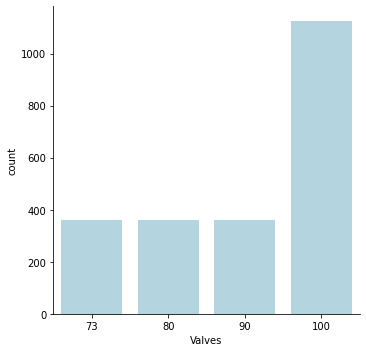

In [147]:
sns.catplot(x="Valves", kind="count", color='lightblue',data=Y);

## handling imbalanced data with SMOTE

In [148]:
fit_valve = umap.UMAP(n_neighbors=200, min_dist=0.0, n_components=4)

In [149]:
%time u_valve = fit.fit_transform(data_trans)


CPU times: user 15.9 s, sys: 190 ms, total: 16.1 s
Wall time: 8.23 s


In [150]:
umap_valve = pd.DataFrame({'Dim_1': u_valve[:, 0], 'Dim_2': u_valve[:, 1]})


In [417]:
X_train_V, X_test_V, y_train_V, y_test_V = train_test_split(X_scaled, z2,test_size=0.4)


In [418]:
#from imblearn.over_sampling import SMOTE

In [419]:
oversample = SMOTE()
X_train_vs, y_train_vs = oversample.fit_resample(X_train_V, y_train_V)


In [420]:
valve_smote = pd.concat([X_train_vs,y_train_vs],axis=1)

In [421]:
valve_smote

0         1         2         3         4         5         6  \
0    -0.633918 -0.497118  0.038951 -5.199338 -0.370918 -0.368685  0.482447   
1    -0.857625 -0.823557 -0.540139 -5.199338 -0.522551 -0.522518  0.458739   
2    -0.292598 -0.106883 -0.137118 -5.199338  0.071684  0.065038 -0.339513   
3    -0.391943 -0.259372  0.061494 -5.199338 -0.298337 -0.300778  0.520679   
4     1.389975  2.012063 -1.852832 -5.199338 -2.532966 -2.569625 -1.411594   
...        ...       ...       ...       ...       ...       ...       ...   
2635 -1.501125 -1.432928 -0.707956 -5.199338 -1.012981 -1.008187  0.045275   
2636  1.436379  1.618105 -1.980912  0.279007 -2.390410 -2.386210 -1.363403   
2637  0.053888  0.044082  0.283499 -5.199338  0.127751  0.132417  0.913152   
2638  0.354621  0.478521  0.879848  1.063211  0.711099  0.724535 -0.135267   
2639  0.052769  0.046791  0.203544 -5.199338  0.164398  0.164162  0.932808   

             7         8         9        10        11        12        13  \
0    -0.368889  0.380499  0.381693  0.385581  0.376916 -0.602054 -0.318132   
1    -0.516250  0.523481  0.520766  0.519885  0.521385 -0.950108  0.520682   
2    -0.003619 -0.096753 -0.104199 -0.108616 -0.064328 -0.181583 -0.102500   
3    -0.293116  0.247020  0.238331  0.257624  0.254540 -0.744710 -0.080985   
4    -2.570041  2.424261  1.727865  2.436692  2.408041  1.362271  1.329807   
...        ...       ...       ...       ...       ...       ...       ...   
2635 -1.038654  1.023642  1.223748  1.020817  1.016058 -1.733553  0.371305   
2636 -2.335649  2.199722  1.622540  2.238131  2.510217  1.359695  1.525683   
2637  0.216465 -0.164495 -0.152776 -0.160104 -0.165653 -0.297968 -0.174149   
2638  1.003714 -0.645518 -0.639056 -0.631704 -0.647484  0.760518 -1.183947   
2639  0.276863 -0.164762 -0.156618 -0.167366 -0.163110 -0.331021 -0.279746   

            14        15        16  Valves  
0    -0.319607 -0.232111  0.687638     100  
1    -0.441983 -0.523537  3.100694     100  
2     0.128772  0.021448 -0.210556     100  
3    -0.197915 -0.251794  1.104546     100  
4    -1.103427 -1.060705 -1.361962     100  
...        ...       ...       ...     ...  
2635 -0.665493 -0.613507  1.142741      90  
2636 -1.223671 -1.181330 -1.324871      90  
2637  0.050415  0.279446  0.970318      90  
2638  0.664683  0.853306 -0.355963      90  
2639 -0.065295  0.188262  1.034187      90  

[2640 rows x 18 columns]

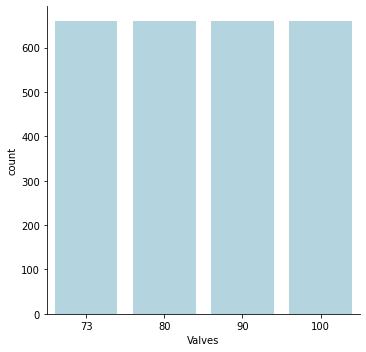

In [422]:
sns.catplot(x="Valves", kind="count", color='lightblue',data=valve_smote);

## Logistic regression for Valves

In [423]:
logModel_v = LogisticRegression()
params = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'], 'max_iter' : [100, 1000,2500, 5000]
}
]

In [424]:
 clf_VL = RandomizedSearchCV(logModel_v, param_distributions = params, cv = 10,verbose=3)
    

In [434]:
best_clf = clf_VL.fit(umap_data,z2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026 
[CV]  solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026, score=nan, total=   0.0s
[CV] solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026 
[CV]  solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026, score=nan, total=   0.0s
[CV] solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026 
[CV]  solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026, score=nan, total=   0.0s
[CV] solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026 
[CV]  solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026, score=nan, total=   0.0s
[CV] solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026 
[CV]  solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026, score=nan, total=   0.0s
[CV] solver=liblinear, penalty=none, max_iter=5000, C=0.615848211066026 
[CV]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 454, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarni

[CV]  solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823, score=0.511, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=2500, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=3792.

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packag

[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246, score=0.339, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246, score=0.430, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246, score=0.511, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246, score=0.509, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246, score=0.509, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=3792.690190732246, score=0.509, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packag

[CV]  solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823, score=0.509, total=   0.1s
[CV] solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823 .
[CV]  solver=saga, penalty=none, max_iter=1000, C=0.08858667904100823, score=0.509, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607, score=0.548, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=5000, C=78.475997035

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607, score=0.430, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607, score=0.511, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607, score=0.509, total=   0.1s
[CV] solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607, score=0.509, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607, score=0.509, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607 ....
[CV]  solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607, score=0.509, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=5000, C=78.47599703514607 ....
[CV]

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  solver=saga, penalty=l1, max_iter=1000, C=0.012742749857031334, score=0.509, total=   0.0s
[CV] solver=saga, penalty=l1, max_iter=1000, C=0.012742749857031334 ..
[CV]  solver=saga, penalty=l1, max_iter=1000, C=0.012742749857031334, score=0.509, total=   0.0s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [435]:
best_clf.best_estimator_

LogisticRegression(C=0.08858667904100823, max_iter=2500, penalty='none',
                   solver='saga')

In [436]:
print (f'Accuracy - : {best_clf.score(umap_data,z2):.3f}')

Accuracy - : 0.506


In [437]:
classifier_LV = LogisticRegression(C=0.08858667904100823, max_iter=2500, penalty='none',
                   solver='saga')
#values from Randomised Search CV
classifier_LV.fit(X_train_vs, y_train_vs)




/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


LogisticRegression(C=0.08858667904100823, max_iter=2500, penalty='none',
                   solver='saga')

In [438]:
y_pred_VL = classifier_LV.predict(X_test_V)

from sklearn.metrics import confusion_matrix 
cm_LV = confusion_matrix(y_test_V, y_pred_VL) 
  
print ("Confusion Matrix : \n", cm_LV) 
print(classification_report(y_test_V, y_pred_VL))

Confusion Matrix : 
 [[132  11   1   0]
 [  3 118  10   0]
 [  1   1 120  20]
 [  0   3  71 391]]
              precision    recall  f1-score   support

          73       0.97      0.92      0.94       144
          80       0.89      0.90      0.89       131
          90       0.59      0.85      0.70       142
         100       0.95      0.84      0.89       465

    accuracy                           0.86       882
   macro avg       0.85      0.88      0.86       882
weighted avg       0.89      0.86      0.87       882



## XGBOOST for Valve

In [431]:

params={
  "objective":['binary','multiclass'],
  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}



In [433]:

classifier_VX=xgboost.XGBClassifier()
random_search_V=RandomizedSearchCV(classifier_VX,param_distributions=params,n_iter=5,cv=10)
random_search_V.fit(X_scaled,z2)


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [410]:
random_search_V.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [411]:
print (f'Accuracy - : {random_search_V.score(umap_data,z2):.3f}')

Accuracy - : 0.986


In [412]:

xgb_V = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=7, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)




xgb_V.fit(X_train_vs, y_train_vs)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [413]:
y_pred_VX = xgb_V.predict(X_test_V)

from sklearn.metrics import confusion_matrix 
cm_VX = confusion_matrix(y_test_V, y_pred_VX) 
  
print ("Confusion Matrix : \n", cm_VX) 
print(classification_report(y_test_V, y_pred_VX))

Confusion Matrix : 
 [[141   4   0   0]
 [  3 134   1   0]
 [  2   2 148   5]
 [  3   1  16 422]]
              precision    recall  f1-score   support

          73       0.95      0.97      0.96       145
          80       0.95      0.97      0.96       138
          90       0.90      0.94      0.92       157
         100       0.99      0.95      0.97       442

    accuracy                           0.96       882
   macro avg       0.95      0.96      0.95       882
weighted avg       0.96      0.96      0.96       882



## LIGHTGBM for Valves

In [414]:


Params = {
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt','dart','goss'],
    'max_depth' : [5,6,7,8], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01,0.02,0.03,0.04,0.05],
    'min_data_in_leaf':[2,4,6,8,10],
    'objective': ['binary','multiclass'], 
    'num_class':[1,2,3,4,5], 
    'metric': ['multi_logloss','roc','auc'] 
    }





In [415]:
#modelling
clf_VLGB = lgb.LGBMClassifier()
random_search_VLGB = RandomizedSearchCV(clf_VLGB,param_distributions=Params,cv = 10)

random_search_VLGB.fit(umap_data,y2)




/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgb

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [5, 6, 7, 8],
                                        'metric': ['multi_logloss', 'roc',
                                                   'auc'],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'min_split_gain': [0.01, 0.02, 0.03,
                                                           0.04, 0.05],
                                        'num_class': [1, 2, 3, 4, 5],
                                        'num_leaves': [90, 200],
                    

In [416]:

random_search_VLGB.best_estimator_

LGBMClassifier(boosting_type='goss', colsample_bytree=0.5, learning_rate=0.05,
               max_depth=5, metric='multi_logloss', min_data_in_leaf=2,
               min_split_gain=0.05, num_class=2, num_leaves=90,
               objective='binary', subsample=0.5)

In [173]:

print (f'Accuracy - : {random_search_VLGB.score(umap_data,y2):.3f}')

Accuracy - : 0.818


In [174]:
lgb_VLGB = lgb.LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.3,
               max_depth=6, metric='multi_logloss', min_data_in_leaf=2,
               min_split_gain=0.03, num_class=3, num_leaves=200,
               objective='binary', subsample=0.7)

lgb_VLGB.fit(X_train_V, y_train_V)


y_pred_VLGB = lgb_VLGB.predict(X_test_V)

from sklearn.metrics import confusion_matrix 
cm_VLGB = confusion_matrix(y_test_V, y_pred_VLGB) 
  
print ("Confusion Matrix : \n", cm_VLGB) 
print(classification_report(y_test_V, y_pred_VLGB))



Confusion Matrix : 
 [[130   7   1   0]
 [  6 128   0   2]
 [  0   5 119  21]
 [  1   1   5 456]]
              precision    recall  f1-score   support

          73       0.95      0.94      0.95       138
          80       0.91      0.94      0.92       136
          90       0.95      0.82      0.88       145
         100       0.95      0.98      0.97       463

    accuracy                           0.94       882
   macro avg       0.94      0.92      0.93       882
weighted avg       0.94      0.94      0.94       882



## Catboost for Valves

In [175]:

params_cat = {
    'grow_policy': ['Lossguide'],
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     'bootstrap_type' :['Bayesian', 'Bernoulli', 'MVS', 'Poisson'],
    'depth' : [5,6,7,8],
    'min_data_in_leaf':[2,4,6,8,10],
    'num_leaves': [90,200]
    }

In [176]:

clf_Vcat = CatBoostClassifier(iterations=200)

In [177]:
random_search_Vcat = RandomizedSearchCV(clf_Vcat,param_distributions=params_cat,cv = 10)

In [178]:
random_search_Vcat.fit(umap_data,y2)


0:	learn: 1.2404843	total: 12ms	remaining: 2.39s
1:	learn: 1.1571476	total: 23.7ms	remaining: 2.35s
2:	learn: 1.0984169	total: 34.4ms	remaining: 2.26s
3:	learn: 1.0524478	total: 45.3ms	remaining: 2.22s
4:	learn: 1.0183764	total: 63.5ms	remaining: 2.48s
5:	learn: 0.9904762	total: 86.3ms	remaining: 2.79s
6:	learn: 0.9592403	total: 107ms	remaining: 2.96s
7:	learn: 0.9412196	total: 131ms	remaining: 3.15s
8:	learn: 0.9294013	total: 147ms	remaining: 3.12s
9:	learn: 0.9125814	total: 156ms	remaining: 2.96s
10:	learn: 0.8979766	total: 165ms	remaining: 2.84s
11:	learn: 0.8796583	total: 175ms	remaining: 2.74s
12:	learn: 0.8675869	total: 180ms	remaining: 2.59s
13:	learn: 0.8573018	total: 187ms	remaining: 2.49s
14:	learn: 0.8533813	total: 193ms	remaining: 2.38s
15:	learn: 0.8415084	total: 201ms	remaining: 2.32s
16:	learn: 0.8303348	total: 224ms	remaining: 2.41s
17:	learn: 0.8244633	total: 231ms	remaining: 2.34s
18:	learn: 0.8162609	total: 240ms	remaining: 2.29s
19:	learn: 0.8107068	total: 245ms	rem

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1731, in _fit
    save_snapshot, snapshot_file, snapshot_interval, init_model
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1659, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx",

0:	learn: 1.2016480	total: 3.54ms	remaining: 705ms
1:	learn: 1.1119251	total: 7.41ms	remaining: 734ms
2:	learn: 1.0669171	total: 11.3ms	remaining: 742ms
3:	learn: 1.0109653	total: 15.2ms	remaining: 745ms
4:	learn: 0.9693711	total: 19.2ms	remaining: 747ms
5:	learn: 0.9421787	total: 22.9ms	remaining: 740ms
6:	learn: 0.9083881	total: 27ms	remaining: 745ms
7:	learn: 0.8728430	total: 31.1ms	remaining: 747ms
8:	learn: 0.8574175	total: 36.2ms	remaining: 769ms
9:	learn: 0.8416625	total: 42.2ms	remaining: 801ms
10:	learn: 0.8284416	total: 46.2ms	remaining: 793ms
11:	learn: 0.8125922	total: 49.9ms	remaining: 781ms
12:	learn: 0.7890267	total: 53.5ms	remaining: 770ms
13:	learn: 0.7757837	total: 57.1ms	remaining: 759ms
14:	learn: 0.7672179	total: 61.3ms	remaining: 755ms
15:	learn: 0.7591690	total: 64.7ms	remaining: 744ms
16:	learn: 0.7512781	total: 68ms	remaining: 732ms
17:	learn: 0.7469124	total: 71ms	remaining: 717ms
18:	learn: 0.7378931	total: 74.7ms	remaining: 712ms
19:	learn: 0.7276526	total: 

RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe7035d1f90>,
                   param_distributions={'bootstrap_type': ['Bayesian',
                                                           'Bernoulli', 'MVS',
                                                           'Poisson'],
                                        'depth': [5, 6, 7, 8],
                                        'grow_policy': ['Lossguide'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'num_leaves': [90, 200]})

In [179]:

random_search_Vcat.best_params_

{'num_leaves': 90,
 'min_data_in_leaf': 8,
 'learning_rate': 0.3,
 'grow_policy': 'Lossguide',
 'depth': 5,
 'bootstrap_type': 'MVS'}

In [180]:

print (f'Accuracy - : {random_search_Vcat.score(umap_data,y2):.3f}')

Accuracy - : 0.847


In [181]:

cat_boost_V = CatBoostClassifier(num_leaves= 200,
 min_data_in_leaf= 2,
 learning_rate= 0.2,
 grow_policy= 'Lossguide',
 depth= 7,
 bootstrap_type= 'Bernoulli')



In [182]:


cat_boost_V.fit(X_train_V, y_train_V)


y_pred_VCat = cat_boost_V.predict(X_test_V)

from sklearn.metrics import confusion_matrix 
cm_VCat = confusion_matrix(y_test_V, y_pred_VCat) 
  
print ("Confusion Matrix : \n", cm_VCat) 
print(classification_report(y_test_V, y_pred_VCat))

0:	learn: 1.1625917	total: 34.8ms	remaining: 34.7s
1:	learn: 1.0138560	total: 75.2ms	remaining: 37.5s
2:	learn: 0.9095096	total: 114ms	remaining: 37.8s
3:	learn: 0.8146646	total: 151ms	remaining: 37.5s
4:	learn: 0.7373164	total: 231ms	remaining: 46s
5:	learn: 0.6876600	total: 269ms	remaining: 44.5s
6:	learn: 0.6389792	total: 312ms	remaining: 44.2s
7:	learn: 0.5985566	total: 351ms	remaining: 43.6s
8:	learn: 0.5737302	total: 381ms	remaining: 42s
9:	learn: 0.5419376	total: 409ms	remaining: 40.5s
10:	learn: 0.5184411	total: 440ms	remaining: 39.5s
11:	learn: 0.5033775	total: 472ms	remaining: 38.9s
12:	learn: 0.4725399	total: 515ms	remaining: 39.1s
13:	learn: 0.4386491	total: 547ms	remaining: 38.5s
14:	learn: 0.4171570	total: 584ms	remaining: 38.3s
15:	learn: 0.4068934	total: 615ms	remaining: 37.8s
16:	learn: 0.3966075	total: 645ms	remaining: 37.3s
17:	learn: 0.3831198	total: 679ms	remaining: 37s
18:	learn: 0.3736570	total: 695ms	remaining: 35.9s
19:	learn: 0.3669600	total: 708ms	remaining: 

# random forest for valves

In [183]:

X_train_rv, X_test_rv, y_train_rv, y_test_rv = train_test_split(X_scaled, y2, test_size = 0.4)



In [184]:
from scipy.stats import randint

est = RandomForestClassifier()
rf_p_dist={'max_depth':[3,5,10,None],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500],
              'max_features':randint(1,3),
               'criterion':['gini','entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':randint(1,4),
              }

<IPython.core.display.Javascript object>

In [185]:
def hypertuning_rscv(est, p_distr, nbr_iter,X,y2):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                   n_iter=nbr_iter, cv=10)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,y2)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [186]:
rf_parameters, rf_ht_score = hypertuning_rscv(est, rf_p_dist, 40, X_scaled, y2)

In [187]:
rf_parameters

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 2,
 'n_estimators': 500}

In [188]:
rf_ht_score

0.5818860551213493

In [439]:
rf_V = RandomForestClassifier(bootstrap = False,
  criterion= 'entropy',
  max_depth= None,
  max_features = 2,
  min_samples_leaf = 2,
  n_estimators = 500)

rf_V.fit(X_train_rv,y_train_rv)


# In[132]:


y_pred_vrf = rf_V.predict(X_test_rv)

from sklearn.metrics import confusion_matrix 
cm_vrf = confusion_matrix(y_test_rv, y_pred_vrf) 
  
print ("Confusion Matrix : \n", cm_vrf) 
print(classification_report(y_test_rv, y_pred_vrf))


<IPython.core.display.Javascript object>

Confusion Matrix : 
 [[120   8   0   2]
 [  8 138   6   1]
 [  2   4 135  12]
 [  4   2   8 432]]
              precision    recall  f1-score   support

          73       0.90      0.92      0.91       130
          80       0.91      0.90      0.90       153
          90       0.91      0.88      0.89       153
         100       0.97      0.97      0.97       446

    accuracy                           0.94       882
   macro avg       0.92      0.92      0.92       882
weighted avg       0.94      0.94      0.94       882



## Pump_leakage

In [190]:
umap_pump = umap_data

In [191]:
umap_pump

Dim_1     Dim_2
0      2.680706 -6.518600
1      2.619900 -6.760943
2      2.634210 -6.844604
3      2.710771 -6.891930
4      2.690090 -6.784121
...         ...       ...
2200  16.867111  9.969485
2201  16.858709  9.964652
2202  16.855274  9.968491
2203  16.856762  9.956568
2204  16.865921  9.941453

[2205 rows x 2 columns]

In [192]:
y3.value_counts()

0    1221
1     492
2     492
Name: Pump_Leakage, dtype: int64

In [193]:
 X_train_pl, X_test_pl, y_train_pl, y_test_pl = train_test_split(umap_pump, y3,test_size=0.4)

In [194]:
X_train_pls, y_train_pls = oversample.fit_resample(X_train_pl, y_train_pl)


In [195]:
pump_smote = pd.concat([X_train_pls,y_train_pls],axis=1)


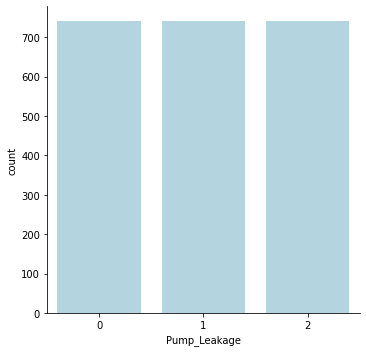

In [196]:
sns.catplot(x="Pump_Leakage", kind="count", color='lightblue',data=pump_smote);


## Logistic regression for pump_leakage

In [197]:
logModel_pl = LogisticRegression()
params = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'], 'max_iter' : [100, 1000,2500, 5000]
}
]

In [198]:
clf_pl = RandomizedSearchCV(logModel_pl, param_distributions = params, cv = 10)


In [199]:
best_clf_pl = clf_pl.fit(umap_pump,y3)


/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_

In [200]:
best_clf_pl.best_estimator_

LogisticRegression(C=1438.44988828766, max_iter=2500, penalty='l1',
                   solver='saga')

In [201]:
print (f'Accuracy - : {best_clf_pl.score(umap_pump,y3):.3f}')


Accuracy - : 0.690


In [202]:
classifier_pl = LogisticRegression(C=0.03359818286283781, max_iter=2500, solver='newton-cg')
#values from Randomised Search CV
classifier_pl.fit(X_train_pl, y_train_pl)

/Users/vijitchekkala/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


LogisticRegression(C=0.03359818286283781, max_iter=2500, solver='newton-cg')

In [203]:
y_pred_pl = classifier_pl.predict(X_test_pl)

from sklearn.metrics import confusion_matrix 
cm_pl = confusion_matrix(y_test_pl, y_pred_pl) 
  
print ("Confusion Matrix : \n", cm_pl) 
print(classification_report(y_test_pl, y_pred_pl))


Confusion Matrix : 
 [[446   0  34]
 [ 51  65  91]
 [ 48  58  89]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       480
           1       0.53      0.31      0.39       207
           2       0.42      0.46      0.44       195

    accuracy                           0.68       882
   macro avg       0.59      0.57      0.57       882
weighted avg       0.66      0.68      0.66       882



## XGBOOST FOR pump leakage

In [204]:
params={
  "objective":['binary','multiclass'],
  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [205]:
classifier_pl=xgboost.XGBClassifier()

random_search_pl=RandomizedSearchCV(classifier_pl,param_distributions=params,n_iter=5,cv=10)

random_search_pl.fit(umap_pump,y3)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [206]:
random_search_pl.best_estimator_


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [207]:
print (f'Accuracy - : {random_search_pl.score(umap_pump,y3):.3f}')


Accuracy - : 0.979


In [208]:
xgb_pl = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)




xgb_pl.fit(X_train_pl, y_train_pl)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [209]:
y_pred_pl = xgb_pl.predict(X_test_pl)

from sklearn.metrics import confusion_matrix 
cm_pl = confusion_matrix(y_test_pl, y_pred_pl) 
  
print ("Confusion Matrix : \n", cm_pl) 
print(classification_report(y_test_pl, y_pred_pl))

Confusion Matrix : 
 [[475   2   3]
 [  6 184  17]
 [  2  28 165]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       480
           1       0.86      0.89      0.87       207
           2       0.89      0.85      0.87       195

    accuracy                           0.93       882
   macro avg       0.91      0.91      0.91       882
weighted avg       0.93      0.93      0.93       882




# LIGHTGBM for pump leakage

In [210]:
Params = {
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt','dart','goss'],
    'max_depth' : [5,6,7,8], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01,0.02,0.03,0.04,0.05],
    'min_data_in_leaf':[2,4,6,8,10],
    'objective': ['binary','multiclass'], 
    'num_class':[1,2,3,4,5], 
    'metric': ['multi_logloss','roc','auc'] 
    }

In [211]:
#modelling
clf_plgb = lgb.LGBMClassifier()
random_search_plgb = RandomizedSearchCV(clf_plgb,param_distributions=Params,cv = 10)

random_search_plgb.fit(umap_pump,y3)

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgb

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [5, 6, 7, 8],
                                        'metric': ['multi_logloss', 'roc',
                                                   'auc'],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'min_split_gain': [0.01, 0.02, 0.03,
                                                           0.04, 0.05],
                                        'num_class': [1, 2, 3, 4, 5],
                                        'num_leaves': [90, 200],
                    

In [212]:
random_search_plgb.best_estimator_

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, max_depth=5,
               metric='multi_logloss', min_data_in_leaf=4, min_split_gain=0.04,
               num_class=3, num_leaves=200, objective='binary', subsample=0.5)

In [213]:
print (f'Accuracy - : {random_search_plgb.score(umap_data,y3):.3f}')


Accuracy - : 0.956


In [214]:
lgb_plgb = lgb.LGBMClassifier(boosting_type='goss', colsample_bytree=0.5, learning_rate=0.15,
               max_depth=7, metric='multi_logloss', min_data_in_leaf=6,
               min_split_gain=0.03, num_class=4, num_leaves=200,
               objective='multiclass', subsample=0.7)

lgb_plgb.fit(X_train_pls, y_train_pls)


y_pred_plgb = lgb_plgb.predict(X_test_pl)

from sklearn.metrics import confusion_matrix 
cm_plgb = confusion_matrix(y_test_pl, y_pred_plgb) 
  
print ("Confusion Matrix : \n", cm_plgb) 
print(classification_report(y_test_pl, y_pred_plgb))


Confusion Matrix : 
 [[471   5   4]
 [  3 190  14]
 [  0  14 181]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       480
           1       0.91      0.92      0.91       207
           2       0.91      0.93      0.92       195

    accuracy                           0.95       882
   macro avg       0.94      0.94      0.94       882
weighted avg       0.96      0.95      0.95       882



## Catboost for Pump_Leakage

In [215]:
params_cat = {
    'grow_policy': ['Lossguide'],
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     'bootstrap_type' :['Bayesian', 'Bernoulli', 'MVS', 'Poisson'],
    'depth' : [5,6,7,8],
    'min_data_in_leaf':[2,4,6,8,10],
    'num_leaves': [90,200]
    }

In [216]:
clf_plcat = CatBoostClassifier(iterations=200)


In [217]:
random_search_plcat = RandomizedSearchCV(clf_plcat,param_distributions=params_cat,cv = 10)


In [218]:
random_search_plcat.fit(umap_data,y3)


0:	learn: 0.8273369	total: 13.6ms	remaining: 2.71s
1:	learn: 0.6619739	total: 25.6ms	remaining: 2.53s
2:	learn: 0.5503195	total: 37.3ms	remaining: 2.45s
3:	learn: 0.4712689	total: 49.2ms	remaining: 2.41s
4:	learn: 0.4065412	total: 60.7ms	remaining: 2.37s
5:	learn: 0.3512713	total: 72.1ms	remaining: 2.33s
6:	learn: 0.3136870	total: 84.2ms	remaining: 2.32s
7:	learn: 0.2825563	total: 95.3ms	remaining: 2.29s
8:	learn: 0.2580624	total: 107ms	remaining: 2.27s
9:	learn: 0.2404287	total: 116ms	remaining: 2.21s
10:	learn: 0.2258794	total: 125ms	remaining: 2.14s
11:	learn: 0.2127777	total: 130ms	remaining: 2.04s
12:	learn: 0.2025717	total: 135ms	remaining: 1.94s
13:	learn: 0.1887688	total: 139ms	remaining: 1.84s
14:	learn: 0.1804612	total: 143ms	remaining: 1.76s
15:	learn: 0.1706509	total: 147ms	remaining: 1.69s
16:	learn: 0.1618501	total: 152ms	remaining: 1.63s
17:	learn: 0.1549586	total: 157ms	remaining: 1.58s
18:	learn: 0.1500489	total: 161ms	remaining: 1.53s
19:	learn: 0.1472589	total: 164ms

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1731, in _fit
    save_snapshot, snapshot_file, snapshot_interval, init_model
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1659, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx",

30:	learn: 0.1261248	total: 129ms	remaining: 702ms
31:	learn: 0.1244369	total: 132ms	remaining: 694ms
32:	learn: 0.1222750	total: 137ms	remaining: 691ms
33:	learn: 0.1216860	total: 139ms	remaining: 681ms
34:	learn: 0.1210556	total: 144ms	remaining: 677ms
35:	learn: 0.1200201	total: 147ms	remaining: 668ms
36:	learn: 0.1190243	total: 151ms	remaining: 667ms
37:	learn: 0.1166082	total: 155ms	remaining: 661ms
38:	learn: 0.1158950	total: 159ms	remaining: 655ms
39:	learn: 0.1150742	total: 162ms	remaining: 650ms
40:	learn: 0.1134078	total: 168ms	remaining: 650ms
41:	learn: 0.1123301	total: 172ms	remaining: 648ms
42:	learn: 0.1117879	total: 175ms	remaining: 638ms
43:	learn: 0.1112000	total: 178ms	remaining: 631ms
44:	learn: 0.1104230	total: 181ms	remaining: 625ms
45:	learn: 0.1099068	total: 184ms	remaining: 617ms
46:	learn: 0.1092676	total: 188ms	remaining: 613ms
47:	learn: 0.1062119	total: 192ms	remaining: 608ms
48:	learn: 0.1057311	total: 196ms	remaining: 604ms
49:	learn: 0.1053684	total: 199

RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe702f94bd0>,
                   param_distributions={'bootstrap_type': ['Bayesian',
                                                           'Bernoulli', 'MVS',
                                                           'Poisson'],
                                        'depth': [5, 6, 7, 8],
                                        'grow_policy': ['Lossguide'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'num_leaves': [90, 200]})

In [219]:
random_search_plcat.best_params_


{'num_leaves': 90,
 'min_data_in_leaf': 4,
 'learning_rate': 0.2,
 'grow_policy': 'Lossguide',
 'depth': 5,
 'bootstrap_type': 'Bayesian'}

In [220]:
print (f'Accuracy - : {random_search_plcat.score(umap_data,y3):.3f}')


Accuracy - : 0.979


In [221]:
cat_boost_pl = CatBoostClassifier(num_leaves= 90,
 min_data_in_leaf= 6,
 learning_rate= 0.25,
 grow_policy= 'Lossguide',
 depth= 6,
 bootstrap_type= 'MVS')

In [222]:
cat_boost_pl.fit(X_train_pls, y_train_pls)


y_pred_plcat = cat_boost_pl.predict(X_test_pl)

from sklearn.metrics import confusion_matrix 
cm_plcat = confusion_matrix(y_test_pl, y_pred_plcat) 
  
print ("Confusion Matrix : \n", cm_plcat) 
print(classification_report(y_test_pl, y_pred_plcat))

0:	learn: 0.7671116	total: 15.1ms	remaining: 15s
1:	learn: 0.6160898	total: 29ms	remaining: 14.5s
2:	learn: 0.5399167	total: 40.8ms	remaining: 13.6s
3:	learn: 0.4701119	total: 53.7ms	remaining: 13.4s
4:	learn: 0.3985532	total: 65.3ms	remaining: 13s
5:	learn: 0.3457038	total: 77.1ms	remaining: 12.8s
6:	learn: 0.2982984	total: 89.6ms	remaining: 12.7s
7:	learn: 0.2654354	total: 101ms	remaining: 12.6s
8:	learn: 0.2464595	total: 112ms	remaining: 12.3s
9:	learn: 0.2281686	total: 147ms	remaining: 14.5s
10:	learn: 0.2057985	total: 220ms	remaining: 19.8s
11:	learn: 0.1945965	total: 231ms	remaining: 19s
12:	learn: 0.1850730	total: 240ms	remaining: 18.2s
13:	learn: 0.1751186	total: 256ms	remaining: 18.1s
14:	learn: 0.1689523	total: 267ms	remaining: 17.5s
15:	learn: 0.1591520	total: 291ms	remaining: 17.9s
16:	learn: 0.1497037	total: 303ms	remaining: 17.5s
17:	learn: 0.1435828	total: 314ms	remaining: 17.2s
18:	learn: 0.1376128	total: 325ms	remaining: 16.8s
19:	learn: 0.1350633	total: 335ms	remainin

## Random forest for Pump Leakage

In [223]:
X_scaled

0         1         2         3         4         5         6  \
0     0.432115  0.712150  1.010782 -5.199338  0.644619  0.660205  2.500301   
1     0.368860  0.626283  0.910464 -5.199338  0.427858  0.427855  2.785077   
2     0.206093  0.489411  0.902517 -5.199338  0.425235  0.425184  3.030750   
3     0.154042  0.422970  0.791323 -5.199338  0.422724  0.422681  3.235754   
4     0.139770  0.323057  0.578386 -5.199338  0.420461  0.420430  1.295503   
...        ...       ...       ...       ...       ...       ...       ...   
2200  1.128252  1.204419  1.391161  2.765184  2.641625  2.616066  1.279667   
2201  1.084977  1.210308  1.248797  2.575908  2.145371  2.040095  1.358864   
2202  1.065018  1.192547  1.061308  2.512549  1.971759  1.880643  1.436721   
2203  1.093589  1.220067  1.823340  2.591854  2.282299  2.262608  1.111279   
2204  1.106841  1.216825  1.484457  2.821293  2.800310  2.746337  1.368465   

             7         8         9        10        11        12        13  \
0     3.091122 -1.200302 -2.539980 -1.378397 -0.436262  0.240346 -0.426470   
1     5.199338 -0.439041 -0.942779 -0.875310 -0.425322  0.157488 -0.464378   
2     3.372127 -0.431419 -0.438275 -0.439094 -0.422605  0.145066 -0.427619   
3     3.084105 -0.427743 -0.431501 -0.433739 -0.420621  0.141248 -0.444425   
4     2.899570 -0.424128 -0.427791 -0.429387 -0.418872  0.137978 -0.425322   
...        ...       ...       ...       ...       ...       ...       ...   
2200  1.563386 -5.199338 -3.094471 -2.901729 -3.128989  0.475629 -0.823172   
2201  1.421742 -3.018146 -3.235538 -2.910812 -2.885511  0.446719 -1.014571   
2202  1.372480 -3.174186 -3.066770 -3.749993 -2.735371  0.409743 -1.191973   
2203  1.439141 -2.838528 -3.063925 -5.199338 -2.918441  0.484730 -1.878205   
2204  1.550999 -2.958185 -5.199338 -3.323533 -5.199338  0.464585 -1.076776   

            14        15        16  
0     0.424035  0.408994  0.394207  
1    -0.433807 -2.409508  0.452950  
2    -0.438290 -2.789479  0.534561  
3    -0.531749 -5.199338  0.869771  
4    -0.877618 -3.179804  0.478865  
...        ...       ...       ...  
2200  0.621153  1.059058  0.246546  
2201  0.696609  0.730028  0.296606  
2202  0.520918  0.588664  0.375953  
2203  0.559430  0.675960  0.175727  
2204  0.639704  0.890041  0.283527  

[2205 rows x 17 columns]

In [224]:
X_train_rpl, X_test_rpl, y_train_rpl, y_test_rpl = train_test_split(X_scaled, y3, test_size = 0.4)


In [225]:

est = RandomForestClassifier()
rf_p_dist={'max_depth':[3,5,10,None],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500],
              'max_features':randint(1,3),
               'criterion':['gini','entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':randint(1,4),
              }

<IPython.core.display.Javascript object>

In [226]:
def hypertuning_rscv(est, p_distr, nbr_iter,X_scaled,y3):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                   n_iter=nbr_iter, cv=10)
    rdmsearch.fit(X_scaled,y3)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [227]:
rf_parameters, rf_ht_score = hypertuning_rscv(est, rf_p_dist, 40, X_scaled, y3)

In [228]:
rf_parameters

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 2,
 'n_estimators': 500}

In [229]:
rf_ht_score

0.9705779514603042

In [230]:
rf_pl = RandomForestClassifier(bootstrap = False,
  criterion= 'entropy',
  max_depth= None,
  max_features = 2,
  min_samples_leaf = 3,
  n_estimators = 500)

rf_pl.fit(X_train_pls,y_train_pls)


# In[132]:


y_pred_rpl = rf_pl.predict(X_test_pl)

from sklearn.metrics import confusion_matrix 
cm_rpl = confusion_matrix(y_test_pl, y_pred_rpl) 
  
print ("Confusion Matrix : \n", cm_rpl) 
print(classification_report(y_test_pl, y_pred_rpl))


<IPython.core.display.Javascript object>

Confusion Matrix : 
 [[469   7   4]
 [  5 187  15]
 [  0  14 181]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       480
           1       0.90      0.90      0.90       207
           2       0.91      0.93      0.92       195

    accuracy                           0.95       882
   macro avg       0.93      0.94      0.93       882
weighted avg       0.95      0.95      0.95       882



## Data Transformation for stable

In [231]:
Z= pd.concat([y_coolerCondition,y_valveCondition,y_pumpLeak,y_hydraulicAcc,y_stableFlag],axis=1)

In [232]:
z2 = Z['Valves']

In [233]:
z4 = Z['Accumulator']

In [234]:
Coolers_stable= y1.replace([3,20,100],['close to failure','reduced Efficieny', 'full efficiency'])

In [235]:
Valve_stable = z2.replace([100,90,80,73],['optimal condition','small lag','severe lag','close to failure'])

In [236]:
Pump_stable = y3.replace([0,1,2],['no leakage','weak leakage','severe leakage'])

In [237]:
Accumulator_stable = z4.replace([130,115,100,90],['optimal','slighlty reduced','severely reduced','close to failure'])

In [238]:
stable_data = pd.concat([Coolers_stable,Valve_stable,Pump_stable,Accumulator_stable],axis=1)

In [239]:
stable_data

Coolers             Valves Pump_Leakage       Accumulator
0     close to failure  optimal condition   no leakage           optimal
1     close to failure  optimal condition   no leakage           optimal
2     close to failure  optimal condition   no leakage           optimal
3     close to failure  optimal condition   no leakage           optimal
4     close to failure  optimal condition   no leakage           optimal
...                ...                ...          ...               ...
2200   full efficiency  optimal condition   no leakage  close to failure
2201   full efficiency  optimal condition   no leakage  close to failure
2202   full efficiency  optimal condition   no leakage  close to failure
2203   full efficiency  optimal condition   no leakage  close to failure
2204   full efficiency  optimal condition   no leakage  close to failure

[2205 rows x 4 columns]

In [240]:
X

PS1         PS2       PS3        PS4       PS5       PS6  \
0     160.673492  109.466914  1.991475   0.000000  9.842170  9.728097   
1     160.603320  109.354890  1.976234   0.000000  9.635142  9.529488   
2     160.347720  109.158845  1.972224   0.000000  9.530548  9.427949   
3     160.188088  109.064807  1.946575   0.000000  9.438827  9.337430   
4     160.000472  108.931434  1.922707   0.000000  9.358762  9.260636   
...          ...         ...       ...        ...       ...       ...   
2200  161.227572  109.779581  2.001438  10.202473  9.972037  9.850361   
2201  161.206070  109.787481  1.998781  10.197919  9.966184  9.844854   
2202  161.192120  109.756174  1.993436  10.196824  9.964329  9.842628   
2203  161.208917  109.793884  2.007077  10.198588  9.968232  9.846690   
2204  161.217128  109.792177  2.002690  10.203126  9.973638  9.851949   

           FS1        FS2        TS1        TS2        TS3        TS4  \
0     6.709815  10.304592  35.621983  40.978767  38.471017  31.745250   
1     6.715315  10.403098  36.676967  41.532767  38.978967  34.493867   
2     6.718522  10.366250  37.880800  42.442450  39.631950  35.646150   
3     6.720565  10.302678  38.879050  43.403983  40.403383  36.579467   
4     6.690308  10.237750  39.803917  44.332750  41.310550  37.427900   
...        ...        ...        ...        ...        ...        ...   
2200  6.689930  10.184515  35.313783  40.874800  38.269267  30.404733   
2201  6.692182  10.177767  35.321600  40.868883  38.268250  30.416233   
2202  6.693277  10.176172  35.319183  40.875950  38.246367  30.426250   
2203  6.684128  10.178353  35.324767  40.876067  38.245733  30.414283   
2204  6.692302  10.183393  35.322233  40.859400  38.248917  30.390800   

               P1       VS1        CE1       CP1        SE1  
0     2538.929167  0.576950  39.601350  1.862750  59.157183  
1     2531.498900  0.565850  25.786433  1.255550  59.335617  
2     2519.928000  0.576533  22.218233  1.113217  59.543150  
3     2511.541633  0.569267  20.459817  1.062150  59.794900  
4     2503.449500  0.577367  19.787017  1.070467  59.455267  
...           ...       ...        ...       ...        ...  
2200  2543.911033  0.550833  46.628517  2.160600  59.033100  
2201  2543.411333  0.547483  46.689817  2.151450  59.068000  
2202  2542.729767  0.545233  46.472300  2.143300  59.132350  
2203  2544.046333  0.537017  46.544967  2.148483  58.970800  
2204  2543.818300  0.546583  46.647933  2.157050  59.053900  

[2205 rows x 17 columns]

In [241]:
s1=X

In [242]:
s2=stable_data

In [243]:
s3=y5

In [244]:
final_stable = pd.concat([s1,s2],axis=1)

In [245]:
final_stable

PS1         PS2       PS3        PS4       PS5       PS6  \
0     160.673492  109.466914  1.991475   0.000000  9.842170  9.728097   
1     160.603320  109.354890  1.976234   0.000000  9.635142  9.529488   
2     160.347720  109.158845  1.972224   0.000000  9.530548  9.427949   
3     160.188088  109.064807  1.946575   0.000000  9.438827  9.337430   
4     160.000472  108.931434  1.922707   0.000000  9.358762  9.260636   
...          ...         ...       ...        ...       ...       ...   
2200  161.227572  109.779581  2.001438  10.202473  9.972037  9.850361   
2201  161.206070  109.787481  1.998781  10.197919  9.966184  9.844854   
2202  161.192120  109.756174  1.993436  10.196824  9.964329  9.842628   
2203  161.208917  109.793884  2.007077  10.198588  9.968232  9.846690   
2204  161.217128  109.792177  2.002690  10.203126  9.973638  9.851949   

           FS1        FS2        TS1        TS2  ...        TS4           P1  \
0     6.709815  10.304592  35.621983  40.978767  ...  31.745250  2538.929167   
1     6.715315  10.403098  36.676967  41.532767  ...  34.493867  2531.498900   
2     6.718522  10.366250  37.880800  42.442450  ...  35.646150  2519.928000   
3     6.720565  10.302678  38.879050  43.403983  ...  36.579467  2511.541633   
4     6.690308  10.237750  39.803917  44.332750  ...  37.427900  2503.449500   
...        ...        ...        ...        ...  ...        ...          ...   
2200  6.689930  10.184515  35.313783  40.874800  ...  30.404733  2543.911033   
2201  6.692182  10.177767  35.321600  40.868883  ...  30.416233  2543.411333   
2202  6.693277  10.176172  35.319183  40.875950  ...  30.426250  2542.729767   
2203  6.684128  10.178353  35.324767  40.876067  ...  30.414283  2544.046333   
2204  6.692302  10.183393  35.322233  40.859400  ...  30.390800  2543.818300   

           VS1        CE1       CP1        SE1           Coolers  \
0     0.576950  39.601350  1.862750  59.157183  close to failure   
1     0.565850  25.786433  1.255550  59.335617  close to failure   
2     0.576533  22.218233  1.113217  59.543150  close to failure   
3     0.569267  20.459817  1.062150  59.794900  close to failure   
4     0.577367  19.787017  1.070467  59.455267  close to failure   
...        ...        ...       ...        ...               ...   
2200  0.550833  46.628517  2.160600  59.033100   full efficiency   
2201  0.547483  46.689817  2.151450  59.068000   full efficiency   
2202  0.545233  46.472300  2.143300  59.132350   full efficiency   
2203  0.537017  46.544967  2.148483  58.970800   full efficiency   
2204  0.546583  46.647933  2.157050  59.053900   full efficiency   

                 Valves Pump_Leakage       Accumulator  
0     optimal condition   no leakage           optimal  
1     optimal condition   no leakage           optimal  
2     optimal condition   no leakage           optimal  
3     optimal condition   no leakage           optimal  
4     optimal condition   no leakage           optimal  
...                 ...          ...               ...  
2200  optimal condition   no leakage  close to failure  
2201  optimal condition   no leakage  close to failure  
2202  optimal condition   no leakage  close to failure  
2203  optimal condition   no leakage  close to failure  
2204  optimal condition   no leakage  close to failure  

[2205 rows x 21 columns]

In [246]:
stable_flag = pd.get_dummies(final_stable,drop_first=True) #dropping the first encoded variable

In [247]:
stable_flag

PS1         PS2       PS3        PS4       PS5       PS6  \
0     160.673492  109.466914  1.991475   0.000000  9.842170  9.728097   
1     160.603320  109.354890  1.976234   0.000000  9.635142  9.529488   
2     160.347720  109.158845  1.972224   0.000000  9.530548  9.427949   
3     160.188088  109.064807  1.946575   0.000000  9.438827  9.337430   
4     160.000472  108.931434  1.922707   0.000000  9.358762  9.260636   
...          ...         ...       ...        ...       ...       ...   
2200  161.227572  109.779581  2.001438  10.202473  9.972037  9.850361   
2201  161.206070  109.787481  1.998781  10.197919  9.966184  9.844854   
2202  161.192120  109.756174  1.993436  10.196824  9.964329  9.842628   
2203  161.208917  109.793884  2.007077  10.198588  9.968232  9.846690   
2204  161.217128  109.792177  2.002690  10.203126  9.973638  9.851949   

           FS1        FS2        TS1        TS2  ...  Coolers_full efficiency  \
0     6.709815  10.304592  35.621983  40.978767  ...                        0   
1     6.715315  10.403098  36.676967  41.532767  ...                        0   
2     6.718522  10.366250  37.880800  42.442450  ...                        0   
3     6.720565  10.302678  38.879050  43.403983  ...                        0   
4     6.690308  10.237750  39.803917  44.332750  ...                        0   
...        ...        ...        ...        ...  ...                      ...   
2200  6.689930  10.184515  35.313783  40.874800  ...                        1   
2201  6.692182  10.177767  35.321600  40.868883  ...                        1   
2202  6.693277  10.176172  35.319183  40.875950  ...                        1   
2203  6.684128  10.178353  35.324767  40.876067  ...                        1   
2204  6.692302  10.183393  35.322233  40.859400  ...                        1   

      Coolers_reduced Efficieny  Valves_optimal condition  Valves_severe lag  \
0                             0                         1                  0   
1                             0                         1                  0   
2                             0                         1                  0   
3                             0                         1                  0   
4                             0                         1                  0   
...                         ...                       ...                ...   
2200                          0                         1                  0   
2201                          0                         1                  0   
2202                          0                         1                  0   
2203                          0                         1                  0   
2204                          0                         1                  0   

      Valves_small lag  Pump_Leakage_severe leakage  \
0                    0                            0   
1                    0                            0   
2                    0                            0   
3                    0                            0   
4                    0                            0   
...                ...                          ...   
2200                 0                            0   
2201                 0                            0   
2202                 0                            0   
2203                 0                            0   
2204                 0                            0   

      Pump_Leakage_weak leakage  Accumulator_optimal  \
0                             0                    1   
1                             0                    1   
2                             0                    1   
3                             0                    1   
4                             0                    1   
...                         ...                  ...   
2200                          0                    0   
2201                          0                    0   
2202                          0      

## Scaling and reducing dimensions for Stable conditions

In [248]:
quantile_stable = quantile.fit_transform(stable_flag)

In [249]:
quantile_stable

array([[ 0.43211465,  0.71214978,  1.01078211, ...,  5.19933758,
        -5.19933758, -5.19933758],
       [ 0.36885956,  0.62628276,  0.91046358, ...,  5.19933758,
        -5.19933758, -5.19933758],
       [ 0.20609304,  0.48941098,  0.90251742, ...,  5.19933758,
        -5.19933758, -5.19933758],
       ...,
       [ 1.06501769,  1.19254651,  1.06130814, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 1.09358945,  1.22006734,  1.82333966, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 1.10684139,  1.21682508,  1.4844574 , ..., -5.19933758,
        -5.19933758, -5.19933758]])

In [250]:
stable_scaled = DataFrame(quantile_stable)

In [251]:
stable_scaled

0         1         2         3         4         5         6   \
0     0.432115  0.712150  1.010782 -5.199338  0.644619  0.660205  2.500301   
1     0.368860  0.626283  0.910464 -5.199338  0.427858  0.427855  2.785077   
2     0.206093  0.489411  0.902517 -5.199338  0.425235  0.425184  3.030750   
3     0.154042  0.422970  0.791323 -5.199338  0.422724  0.422681  3.235754   
4     0.139770  0.323057  0.578386 -5.199338  0.420461  0.420430  1.295503   
...        ...       ...       ...       ...       ...       ...       ...   
2200  1.128252  1.204419  1.391161  2.765184  2.641625  2.616066  1.279667   
2201  1.084977  1.210308  1.248797  2.575908  2.145371  2.040095  1.358864   
2202  1.065018  1.192547  1.061308  2.512549  1.971759  1.880643  1.436721   
2203  1.093589  1.220067  1.823340  2.591854  2.282299  2.262608  1.111279   
2204  1.106841  1.216825  1.484457  2.821293  2.800310  2.746337  1.368465   

            7         8         9   ...        17        18        19  \
0     3.091122 -1.200302 -2.539980  ... -5.199338 -5.199338  5.199338   
1     5.199338 -0.439041 -0.942779  ... -5.199338 -5.199338  5.199338   
2     3.372127 -0.431419 -0.438275  ... -5.199338 -5.199338  5.199338   
3     3.084105 -0.427743 -0.431501  ... -5.199338 -5.199338  5.199338   
4     2.899570 -0.424128 -0.427791  ... -5.199338 -5.199338  5.199338   
...        ...       ...       ...  ...       ...       ...       ...   
2200  1.563386 -5.199338 -3.094471  ...  5.199338 -5.199338  5.199338   
2201  1.421742 -3.018146 -3.235538  ...  5.199338 -5.199338  5.199338   
2202  1.372480 -3.174186 -3.066770  ...  5.199338 -5.199338  5.199338   
2203  1.439141 -2.838528 -3.063925  ...  5.199338 -5.199338  5.199338   
2204  1.550999 -2.958185 -5.199338  ...  5.199338 -5.199338  5.199338   

            20        21        22        23        24        25        26  
0    -5.199338 -5.199338 -5.199338 -5.199338  5.199338 -5.199338 -5.199338  
1    -5.199338 -5.199338 -5.199338 -5.199338  5.199338 -5.199338 -5.199338  
2    -5.199338 -5.199338 -5.199338 -5.199338  5.199338 -5.199338 -5.199338  
3    -5.199338 -5.199338 -5.199338 -5.199338  5.199338 -5.199338 -5.199338  
4    -5.199338 -5.199338 -5.199338 -5.199338  5.199338 -5.199338 -5.199338  
...        ...       ...       ...       ...       ...       ...       ...  
2200 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338  
2201 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338  
2202 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338  
2203 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338  
2204 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338  

[2205 rows x 27 columns]

In [252]:
%time umap_stable = fit.fit_transform(stable_scaled)

CPU times: user 14.5 s, sys: 267 ms, total: 14.8 s
Wall time: 7.85 s


In [253]:
umap_stable = pd.DataFrame({'Dim_1': umap_stable[:, 0], 'Dim_2': umap_stable[:, 1]})

In [254]:
y5.value_counts()

0    1449
1     756
Name: Stable, dtype: int64

## Splitting data and Hanlding Classification Imbalance

In [255]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(umap_stable, y5,test_size=0.4)


In [256]:

X_train_ss, y_train_ss = oversample.fit_resample(X_train_s, y_train_s)

In [257]:
s_smote = pd.concat([X_train_ss,y_train_ss],axis=1)


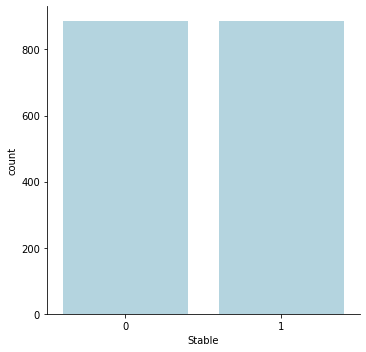

In [258]:
sns.catplot(x="Stable", kind="count", color='lightblue',data=s_smote);


In [259]:
logModel_s = LogisticRegression()
params = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'], 'max_iter' : [100, 1000,2500, 5000]
}
]

In [260]:
clf_s = RandomizedSearchCV(logModel_s, param_distributions = params, cv = 10)


In [261]:
best_clf_s = clf_s.fit(umap_stable,y5)


/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 450, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valid

In [262]:
best_clf_s.best_estimator_


LogisticRegression(C=0.004832930238571752, max_iter=1000, penalty='none')

In [263]:
print (f'Accuracy - : {best_clf_s.score(umap_stable,y5):.3f}')


Accuracy - : 0.784


In [264]:
classifier_s = LogisticRegression(C=1438.44988828766, max_iter=5000, solver='liblinear')
#values from Randomised Search CV
classifier_s.fit(X_train_ss, y_train_ss)

LogisticRegression(C=1438.44988828766, max_iter=5000, solver='liblinear')

In [265]:
y_pred_s = classifier_s.predict(X_test_s)

from sklearn.metrics import confusion_matrix 
cm_s = confusion_matrix(y_test_s, y_pred_s) 
  
print ("Confusion Matrix : \n", cm_s) 
print(classification_report(y_test_s, y_pred_s))

Confusion Matrix : 
 [[476  87]
 [133 186]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       563
           1       0.68      0.58      0.63       319

    accuracy                           0.75       882
   macro avg       0.73      0.71      0.72       882
weighted avg       0.75      0.75      0.75       882



## XGBOOST for stable

In [266]:
params={
  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [267]:
classifier_s=xgboost.XGBClassifier()

random_search_s=RandomizedSearchCV(classifier_s,param_distributions=params,n_iter=5,cv=10)

random_search_s.fit(umap_stable,y5)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [268]:
random_search_s.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [269]:
print (f'Accuracy - : {random_search_s.score(umap_stable,y5):.3f}')


Accuracy - : 0.963


In [270]:
xgb_sx = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=5,  monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)




xgb_sx.fit(X_train_s, y_train_s)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [271]:
y_pred_sx = xgb_sx.predict(X_test_s)

from sklearn.metrics import confusion_matrix 
cm_sx = confusion_matrix(y_test_s, y_pred_sx) 
  
print ("Confusion Matrix : \n", cm_sx) 
print(classification_report(y_test_s, y_pred_sx))

Confusion Matrix : 
 [[541  22]
 [ 42 277]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       563
           1       0.93      0.87      0.90       319

    accuracy                           0.93       882
   macro avg       0.93      0.91      0.92       882
weighted avg       0.93      0.93      0.93       882



## Lightgbm for Stable Condition


In [272]:
Params = {
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt','dart','goss'],
    'max_depth' : [5,6,7,8], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01,0.02,0.03,0.04,0.05],
    'min_data_in_leaf':[2,4,6,8,10], 
    'metric': ['multi_logloss','roc','auc'] 
    }

In [273]:
#modelling
clf_slgb = lgb.LGBMClassifier()
random_search_slgb = RandomizedSearchCV(clf_slgb,param_distributions=Params,cv = 10)

random_search_slgb.fit(umap_stable,y5)

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgb

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [5, 6, 7, 8],
                                        'metric': ['multi_logloss', 'roc',
                                                   'auc'],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'min_split_gain': [0.01, 0.02, 0.03,
                                                           0.04, 0.05],
                                        'num_leaves': [90, 200],
                                        'subsample': [0.5, 0.7]})

In [274]:
random_search_slgb.best_estimator_


LGBMClassifier(boosting_type='dart', colsample_bytree=0.7, learning_rate=0.05,
               max_depth=7, metric='roc', min_data_in_leaf=10,
               min_split_gain=0.01, num_leaves=200, subsample=0.7)

In [275]:
print (f'Accuracy - : {random_search_slgb.score(umap_stable,y5):.3f}')


Accuracy - : 0.955


In [276]:
lgb_slgb = lgb.LGBMClassifier(colsample_bytree=0.5, max_depth=5, metric='roc',
               min_data_in_leaf=8, min_split_gain=0.01, num_leaves=90,
               subsample=0.7)

lgb_slgb.fit(X_train_ss, y_train_ss)


y_pred_slgb = lgb_slgb.predict(X_test_s)

from sklearn.metrics import confusion_matrix 
cm_slgb = confusion_matrix(y_test_s, y_pred_slgb) 
  
print ("Confusion Matrix : \n", cm_slgb) 
print(classification_report(y_test_s, y_pred_slgb))

Confusion Matrix : 
 [[537  26]
 [ 29 290]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       563
           1       0.92      0.91      0.91       319

    accuracy                           0.94       882
   macro avg       0.93      0.93      0.93       882
weighted avg       0.94      0.94      0.94       882



## CATBOOST for stable

In [277]:
#setting parameters for catboost 
params_cat = {
    'grow_policy': ['Lossguide'],
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     'bootstrap_type' :['Bayesian', 'Bernoulli', 'MVS', 'Poisson'],
    'depth' : [5,6,7,8],
    'min_data_in_leaf':[2,4,6,8,10],
    'num_leaves': [90,200]
    }

In [278]:
clf_scat = CatBoostClassifier(iterations=200)


In [279]:
random_search_scat = RandomizedSearchCV(clf_scat,param_distributions=params_cat,cv = 5)


In [280]:
random_search_scat.fit(umap_stable,y5)

0:	learn: 0.4053609	total: 29.1ms	remaining: 5.8s
1:	learn: 0.2739820	total: 42.6ms	remaining: 4.22s
2:	learn: 0.2051188	total: 60.2ms	remaining: 3.95s
3:	learn: 0.1729893	total: 78.3ms	remaining: 3.84s
4:	learn: 0.1585676	total: 88.9ms	remaining: 3.47s
5:	learn: 0.1499274	total: 100ms	remaining: 3.25s
6:	learn: 0.1446764	total: 112ms	remaining: 3.09s
7:	learn: 0.1359516	total: 123ms	remaining: 2.96s
8:	learn: 0.1340784	total: 130ms	remaining: 2.75s
9:	learn: 0.1276507	total: 137ms	remaining: 2.61s
10:	learn: 0.1217756	total: 142ms	remaining: 2.44s
11:	learn: 0.1200597	total: 145ms	remaining: 2.28s
12:	learn: 0.1158556	total: 150ms	remaining: 2.16s
13:	learn: 0.1146543	total: 155ms	remaining: 2.05s
14:	learn: 0.1119536	total: 159ms	remaining: 1.96s
15:	learn: 0.1102194	total: 162ms	remaining: 1.87s
16:	learn: 0.1079140	total: 168ms	remaining: 1.81s
17:	learn: 0.1054024	total: 173ms	remaining: 1.75s
18:	learn: 0.1034313	total: 178ms	remaining: 1.69s
19:	learn: 0.1027848	total: 181ms	rem

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1731, in _fit
    save_snapshot, snapshot_file, snapshot_interval, init_model
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1659, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx",

1:	learn: 0.3464635	total: 11.2ms	remaining: 1.11s
2:	learn: 0.2431738	total: 18.3ms	remaining: 1.2s
3:	learn: 0.2125156	total: 22.3ms	remaining: 1.09s
4:	learn: 0.1826498	total: 27.4ms	remaining: 1.07s
5:	learn: 0.1639064	total: 33.5ms	remaining: 1.08s
6:	learn: 0.1562095	total: 36ms	remaining: 994ms
7:	learn: 0.1558782	total: 37.2ms	remaining: 894ms
8:	learn: 0.1439381	total: 42.4ms	remaining: 901ms
9:	learn: 0.1363150	total: 47.1ms	remaining: 895ms
10:	learn: 0.1343530	total: 51.1ms	remaining: 878ms
11:	learn: 0.1280439	total: 56.9ms	remaining: 892ms
12:	learn: 0.1241431	total: 61.3ms	remaining: 882ms
13:	learn: 0.1214136	total: 65.9ms	remaining: 875ms
14:	learn: 0.1197818	total: 71.7ms	remaining: 884ms
15:	learn: 0.1196993	total: 73.3ms	remaining: 842ms
16:	learn: 0.1179165	total: 77.1ms	remaining: 830ms
17:	learn: 0.1154167	total: 80.7ms	remaining: 816ms
18:	learn: 0.1137168	total: 85ms	remaining: 810ms
19:	learn: 0.1134334	total: 87.4ms	remaining: 787ms
20:	learn: 0.1114452	total

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe707024750>,
                   param_distributions={'bootstrap_type': ['Bayesian',
                                                           'Bernoulli', 'MVS',
                                                           'Poisson'],
                                        'depth': [5, 6, 7, 8],
                                        'grow_policy': ['Lossguide'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'num_leaves': [90, 200]})

In [281]:
random_search_scat.best_params_


{'num_leaves': 90,
 'min_data_in_leaf': 6,
 'learning_rate': 0.3,
 'grow_policy': 'Lossguide',
 'depth': 7,
 'bootstrap_type': 'Bayesian'}

In [282]:
print (f'Accuracy - : {random_search_scat.score(umap_stable,y5):.3f}')


Accuracy - : 0.970


In [283]:
cat_boost_s = CatBoostClassifier(num_leaves= 200,
 min_data_in_leaf= 2,
 learning_rate= 0.1,
 grow_policy= 'Lossguide',
 depth= 7,
 bootstrap_type= 'Bernoulli')

In [284]:
cat_boost_s.fit(X_train_s, y_train_s)


y_pred_scat = cat_boost_s.predict(X_test_s)



0:	learn: 0.5853946	total: 6.94ms	remaining: 6.93s
1:	learn: 0.4967795	total: 15.8ms	remaining: 7.88s
2:	learn: 0.4403944	total: 21.4ms	remaining: 7.12s
3:	learn: 0.3841175	total: 28ms	remaining: 6.97s
4:	learn: 0.3407514	total: 34.7ms	remaining: 6.91s
5:	learn: 0.3109202	total: 40.7ms	remaining: 6.74s
6:	learn: 0.2778199	total: 48ms	remaining: 6.81s
7:	learn: 0.2632513	total: 52.8ms	remaining: 6.55s
8:	learn: 0.2365789	total: 70.1ms	remaining: 7.72s
9:	learn: 0.2181581	total: 79.6ms	remaining: 7.88s
10:	learn: 0.2066530	total: 86.2ms	remaining: 7.75s
11:	learn: 0.1942392	total: 93.4ms	remaining: 7.69s
12:	learn: 0.1883885	total: 100ms	remaining: 7.59s
13:	learn: 0.1807869	total: 106ms	remaining: 7.44s
14:	learn: 0.1725669	total: 112ms	remaining: 7.34s
15:	learn: 0.1649638	total: 119ms	remaining: 7.29s
16:	learn: 0.1610199	total: 125ms	remaining: 7.22s
17:	learn: 0.1540526	total: 143ms	remaining: 7.78s
18:	learn: 0.1479096	total: 151ms	remaining: 7.79s
19:	learn: 0.1438575	total: 158ms

In [447]:
from sklearn.metrics import confusion_matrix 
cm_scat = confusion_matrix(y_test_s, y_pred_scat) 
  
print ("Confusion Matrix : \n", cm_scat) 
print(classification_report(y_test_s, y_pred_scat))

Confusion Matrix : 
 [[539  24]
 [ 32 287]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       563
           1       0.92      0.90      0.91       319

    accuracy                           0.94       882
   macro avg       0.93      0.93      0.93       882
weighted avg       0.94      0.94      0.94       882



## Random Forest for stable

In [285]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(stable_scaled, y5, test_size = 0.4)


In [286]:
#Setting parameter for random forest classifier
est = RandomForestClassifier()
rf_p_dist={'max_depth':[3,5,10,None],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500],
              'max_features':randint(1,3),
               'criterion':['gini','entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':randint(1,4),
              }

<IPython.core.display.Javascript object>

In [287]:
#fitting randomisedsearchcv for random forest
def hypertuning_rscv(est, p_distr, nbr_iter,stable_scaled,y5):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                   n_iter=nbr_iter, cv=10)
    rdmsearch.fit(stable_scaled,y5)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [288]:
rf_parameters, rf_ht_score = hypertuning_rscv(est, rf_p_dist, 40, stable_scaled, y5)


In [289]:
rf_parameters


{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 2,
 'min_samples_leaf': 1,
 'n_estimators': 350}

In [290]:
rf_ht_score

0.8743233237350886

In [291]:
rf_s = RandomForestClassifier(bootstrap = True,
  criterion= 'entropy',
  max_depth= 3,
  max_features = 1,
  min_samples_leaf = 2,
  n_estimators = 150)

rf_s.fit(X_train_rs,y_train_rs)


# In[132]:


y_pred_rs = rf_s.predict(X_test_rs)

from sklearn.metrics import confusion_matrix 
cm_rs = confusion_matrix(y_test_rs, y_pred_rs) 
  
print ("Confusion Matrix : \n", cm_rs) 
print(classification_report(y_test_rs, y_pred_rs))

<IPython.core.display.Javascript object>

Confusion Matrix : 
 [[585   0]
 [ 58 239]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       585
           1       1.00      0.80      0.89       297

    accuracy                           0.93       882
   macro avg       0.95      0.90      0.92       882
weighted avg       0.94      0.93      0.93       882



In [292]:
umap_stable

Dim_1      Dim_2
0     -3.306521  20.832310
1     -3.276606  20.840992
2     -3.311795  20.870195
3     -3.179486  20.802940
4     -3.297639  20.873388
...         ...        ...
2200  17.349274   9.930968
2201  17.351065   9.933259
2202  17.341005   9.916590
2203  17.340261   9.897032
2204  17.348839   9.929359

[2205 rows x 2 columns]

In [293]:
#umap_stable.to_csv(r'/Users/vijitchekkala/Desktop/Hydraulics/Data/umap_stable.csv')

## Accumaltors

In [294]:
 X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_scaled, z4,test_size=0.4)


In [295]:
z4.value_counts()

90     808
130    599
115    399
100    399
Name: Accumulator, dtype: int64

# Handling accumatlors data using SMOTE

In [296]:
X_train_as, y_train_as = oversample.fit_resample(X_train_a, y_train_a)

In [297]:
acc_smote = pd.concat([X_train_as,y_train_as],axis=1)


In [298]:
z4

0       130
1       130
2       130
3       130
4       130
       ... 
2200     90
2201     90
2202     90
2203     90
2204     90
Name: Accumulator, Length: 2205, dtype: int64

<Figure size 864x576 with 0 Axes>

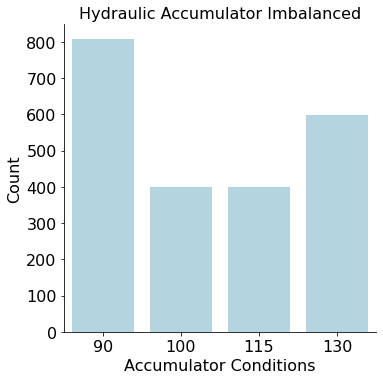

In [299]:
plt.figure(figsize=(12,8))
sns.catplot(x="Accumulator", kind="count", color='lightblue',data=Y);
plt.title("Hydraulic Accumulator Imbalanced", size = 16)
plt.xlabel("Accumulator Conditions",size=16)
plt.xticks(fontsize=16)
plt.ylabel("Count",size=16)
plt.yticks(fontsize=16)
plt.savefig('/Users/vijitchekkala/Desktop/RIC_DIAGRAMS/acc_imbal.png')

<Figure size 864x576 with 0 Axes>

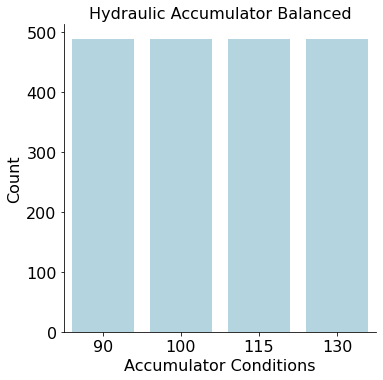

In [300]:
plt.figure(figsize=(12,8))
sns.catplot(x="Accumulator", kind="count", color='lightblue',data=acc_smote);
plt.title("Hydraulic Accumulator Balanced", size = 16)
plt.xlabel("Accumulator Conditions",size=16)
plt.xticks(fontsize=16)
plt.ylabel("Count",size=16)
plt.yticks(fontsize=16)
plt.savefig('/Users/vijitchekkala/Desktop/RIC_DIAGRAMS/acc_bal.png')

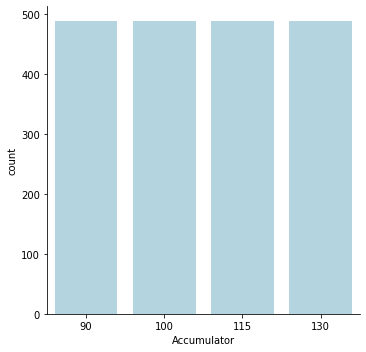

In [301]:
sns.catplot(x="Accumulator", kind="count", color='lightblue',data=acc_smote);


# Logistic regression for Hydraulic Accumulator

In [302]:
logModel_a = LogisticRegression()
params = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'], 'max_iter' : [100, 1000,2500, 5000]
}
]

In [303]:
clf_al = RandomizedSearchCV(logModel_a, param_distributions = params, cv = 10,verbose=3)


In [304]:
best_clf = clf_al.fit(umap_data,z4)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781 .....
[CV]  solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781 .....
[CV]  solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781 .....
[CV]  solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781 .....
[CV]  solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781 .....
[CV]  solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781, score=nan, total=   0.0s
[CV] solver=sag, penalty=l1, max_iter=100, C=0.03359818286283781 .....
[CV]  solver=sag, penalty=l1, max_iter=100, C=0.033

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Paral

[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=0.0018329807108324356, score=0.000, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=0.0018329807108324356 
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=0.0018329807108324356, score=0.045, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=0.0018329807108324356 
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=0.0018329807108324356, score=0.277, total=   0.0s
[CV] solver=lbfgs, penalty=l2, max_iter=2500, C=0.0018329807108324356 
[CV]  solver=lbfgs, penalty=l2, max_iter=2500, C=0.0018329807108324356, score=0.141, total=   0.0s
[CV] solver=liblinear, penalty=l1, max_iter=5000, C=11.288378916846883 
[CV]  solver=liblinear, penalty=l1, max_iter=5000, C=11.288378916846883, score=0.181, total=   0.0s
[CV] solver=liblinear, penalty=l1, max_iter=5000, C=11.288378916846883 
[CV]  solver=liblinear, penalty=l1, max_iter=5000, C=11.288378916846883, score=0.484, total=   0.0s
[CV] solver=liblinear, penalty=l1, max_iter=500

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

[CV]  solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583, score=0.149, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583 
[CV]  solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583, score=0.385, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583 
[CV]  solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583, score=0.367, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583 
[CV]  solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583, score=0.364, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583 
[CV]  solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583, score=0.000, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583 
[CV]  solver=sag, penalty=none, max_iter=5000, C=0.00026366508987303583, score=0.045, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396, score=0.181, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396, score=0.484, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396, score=0.457, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396, score=0.385, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396, score=0.367, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396 
[CV]  solver=liblinear, penalty=l2, max_iter=5000, C=4.281332398719396, score=0.364, total=   0.0s
[CV] solver=liblinear, penalty=l2, max_iter=5000, C

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_select

In [305]:
best_clf.best_estimator_


LogisticRegression(C=11.288378916846883, max_iter=5000, penalty='l1',
                   solver='liblinear')

In [306]:
print (f'Accuracy - : {best_clf.score(umap_data,z4):.3f}')

Accuracy - : 0.374


In [307]:
classifier_al = LogisticRegression(C=0.012742749857031334, max_iter=2500, penalty='none',
                   solver='newton-cg')
#values from Randomised Search CV
classifier_al.fit(X_train_as, y_train_as)

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


LogisticRegression(C=0.012742749857031334, max_iter=2500, penalty='none',
                   solver='newton-cg')

In [308]:
y_pred_al = classifier_al.predict(X_test_a)

from sklearn.metrics import confusion_matrix 
cm_al = confusion_matrix(y_test_a, y_pred_al) 
  
print ("Confusion Matrix : \n", cm_al) 
print(classification_report(y_test_a, y_pred_al))

Confusion Matrix : 
 [[232  42  29  17]
 [ 52  73  27   4]
 [  3  29 109  27]
 [  9   4  31 194]]
              precision    recall  f1-score   support

          90       0.78      0.72      0.75       320
         100       0.49      0.47      0.48       156
         115       0.56      0.65      0.60       168
         130       0.80      0.82      0.81       238

    accuracy                           0.69       882
   macro avg       0.66      0.66      0.66       882
weighted avg       0.69      0.69      0.69       882



## XGBoost for hydraulic accumulator

In [309]:
params={
  "objective":['binary','multiclass'],
  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [310]:
classifier_ax=xgboost.XGBClassifier()
random_search_a = RandomizedSearchCV(classifier_ax,param_distributions=params,n_iter=5,cv=10)
random_search_a.fit(umap_data,z4)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [311]:
random_search_a.best_estimator_


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.25, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [312]:
print (f'Accuracy - : {random_search_a.score(umap_data,z4):.3f}')

Accuracy - : 0.911


In [313]:
xgb_ax = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)




xgb_ax.fit(X_train_as, y_train_as)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [314]:
y_pred_ax = xgb_ax.predict(X_test_a)

from sklearn.metrics import confusion_matrix 
cm_ax = confusion_matrix(y_test_a, y_pred_ax) 
  
print ("Confusion Matrix : \n", cm_ax) 
print(classification_report(y_test_a, y_pred_ax))

Confusion Matrix : 
 [[308  10   2   0]
 [  1 150   5   0]
 [  0   2 165   1]
 [  1   0   1 236]]
              precision    recall  f1-score   support

          90       0.99      0.96      0.98       320
         100       0.93      0.96      0.94       156
         115       0.95      0.98      0.97       168
         130       1.00      0.99      0.99       238

    accuracy                           0.97       882
   macro avg       0.97      0.97      0.97       882
weighted avg       0.97      0.97      0.97       882



## LightGBM for Hydraulic accumulator

In [315]:
Params = {
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt','dart','goss'],
    'max_depth' : [5,6,7,8], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01,0.02,0.03,0.04,0.05],
    'min_data_in_leaf':[2,4,6,8,10],
    'objective': ['binary','multiclass'], 
    'num_class':[1,2,3,4,5], 
    'metric': ['multi_logloss','roc','auc'] 
    }

In [316]:
clf_algb = lgb.LGBMClassifier()
random_search_algb = RandomizedSearchCV(clf_algb,param_distributions=Params,cv = 10)

random_search_algb.fit(umap_data,z4)

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/lightgb

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [5, 6, 7, 8],
                                        'metric': ['multi_logloss', 'roc',
                                                   'auc'],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'min_split_gain': [0.01, 0.02, 0.03,
                                                           0.04, 0.05],
                                        'num_class': [1, 2, 3, 4, 5],
                                        'num_leaves': [90, 200],
                    

In [317]:
random_search_algb.best_estimator_

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.15, max_depth=8,
               metric='multi_logloss', min_data_in_leaf=8, min_split_gain=0.02,
               num_class=2, num_leaves=90, objective='multiclass',
               subsample=0.7)

In [318]:
print (f'Accuracy - : {random_search_algb.score(umap_data,z4):.3f}')


Accuracy - : 0.926


In [319]:
lgb_algb = lgb.LGBMClassifier(colsample_bytree=0.5, learning_rate=0.15, max_depth=6,
               metric='multi_logloss', min_data_in_leaf=10, min_split_gain=0.03,
               num_class=2, num_leaves=200, objective='binary', subsample=0.5)

lgb_algb.fit(X_train_as, y_train_as)


y_pred_algb = lgb_algb.predict(X_test_a)

from sklearn.metrics import confusion_matrix 
cm_algb = confusion_matrix(y_test_a, y_pred_algb) 
  
print ("Confusion Matrix : \n", cm_algb) 
print(classification_report(y_test_a, y_pred_algb))

Confusion Matrix : 
 [[307  11   2   0]
 [  0 153   3   0]
 [  1   2 165   0]
 [  2   0   1 235]]
              precision    recall  f1-score   support

          90       0.99      0.96      0.97       320
         100       0.92      0.98      0.95       156
         115       0.96      0.98      0.97       168
         130       1.00      0.99      0.99       238

    accuracy                           0.98       882
   macro avg       0.97      0.98      0.97       882
weighted avg       0.98      0.98      0.98       882



## Catboost for hydraulic accumulator

In [320]:
params_cat = {
    'grow_policy': ['Lossguide'],
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     'bootstrap_type' :['Bayesian', 'Bernoulli', 'MVS', 'Poisson'],
    'depth' : [5,6,7,8],
    'min_data_in_leaf':[2,4,6,8,10],
    'num_leaves': [90,200]
    }

In [321]:
clf_acat = CatBoostClassifier(iterations=200)

In [322]:
random_search_acat = RandomizedSearchCV(clf_acat,param_distributions=params_cat,cv = 10)


In [323]:
random_search_acat.fit(umap_data,z4)


0:	learn: 1.0132113	total: 16ms	remaining: 3.18s
1:	learn: 0.8402086	total: 31.2ms	remaining: 3.09s
2:	learn: 0.7484382	total: 45.6ms	remaining: 2.99s
3:	learn: 0.6682100	total: 60.9ms	remaining: 2.98s
4:	learn: 0.6108560	total: 74.9ms	remaining: 2.92s
5:	learn: 0.5714107	total: 89.3ms	remaining: 2.89s
6:	learn: 0.5338605	total: 103ms	remaining: 2.85s
7:	learn: 0.4982926	total: 121ms	remaining: 2.9s
8:	learn: 0.4587273	total: 139ms	remaining: 2.94s
9:	learn: 0.4331509	total: 154ms	remaining: 2.92s
10:	learn: 0.4161332	total: 162ms	remaining: 2.78s
11:	learn: 0.4002399	total: 169ms	remaining: 2.64s
12:	learn: 0.3894257	total: 176ms	remaining: 2.53s
13:	learn: 0.3710611	total: 188ms	remaining: 2.49s
14:	learn: 0.3633145	total: 194ms	remaining: 2.39s
15:	learn: 0.3518413	total: 202ms	remaining: 2.32s
16:	learn: 0.3418993	total: 213ms	remaining: 2.29s
17:	learn: 0.3302645	total: 224ms	remaining: 2.27s
18:	learn: 0.3194442	total: 233ms	remaining: 2.22s
19:	learn: 0.3121859	total: 241ms	rema

/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1731, in _fit
    save_snapshot, snapshot_file, snapshot_interval, init_model
  File "/Users/vijitchekkala/anaconda3/lib/python3.7/site-packages/catboost/core.py", line 1659, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx",

21:	learn: 0.6738921	total: 73.1ms	remaining: 591ms
22:	learn: 0.6627897	total: 76.5ms	remaining: 589ms
23:	learn: 0.6513255	total: 79.7ms	remaining: 584ms
24:	learn: 0.6434366	total: 82.4ms	remaining: 577ms
25:	learn: 0.6342552	total: 85.6ms	remaining: 573ms
26:	learn: 0.6245368	total: 88.8ms	remaining: 569ms
27:	learn: 0.6221119	total: 97.1ms	remaining: 596ms
28:	learn: 0.6172028	total: 99.8ms	remaining: 589ms
29:	learn: 0.6006074	total: 103ms	remaining: 584ms
30:	learn: 0.5933221	total: 106ms	remaining: 580ms
31:	learn: 0.5873752	total: 110ms	remaining: 576ms
32:	learn: 0.5791789	total: 113ms	remaining: 572ms
33:	learn: 0.5706146	total: 116ms	remaining: 567ms
34:	learn: 0.5665237	total: 119ms	remaining: 560ms
35:	learn: 0.5636735	total: 121ms	remaining: 553ms
36:	learn: 0.5569262	total: 125ms	remaining: 549ms
37:	learn: 0.5529201	total: 128ms	remaining: 544ms
38:	learn: 0.5441106	total: 131ms	remaining: 541ms
39:	learn: 0.5343990	total: 134ms	remaining: 537ms
40:	learn: 0.5313568	to

RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe702f9f890>,
                   param_distributions={'bootstrap_type': ['Bayesian',
                                                           'Bernoulli', 'MVS',
                                                           'Poisson'],
                                        'depth': [5, 6, 7, 8],
                                        'grow_policy': ['Lossguide'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10],
                                        'num_leaves': [90, 200]})

In [324]:
random_search_acat.best_params_


{'num_leaves': 90,
 'min_data_in_leaf': 6,
 'learning_rate': 0.3,
 'grow_policy': 'Lossguide',
 'depth': 8,
 'bootstrap_type': 'Bayesian'}

In [325]:
print (f'Accuracy - : {random_search_acat.score(umap_data,z4):.3f}')


Accuracy - : 0.945


In [326]:
cat_boost_a = CatBoostClassifier(num_leaves= 200,
 min_data_in_leaf= 10,
 learning_rate= 0.25,
 grow_policy= 'Lossguide',
 depth= 5,
 bootstrap_type= 'Bernoulli')

In [327]:
cat_boost_a.fit(X_train_as, y_train_as)


y_pred_acat = cat_boost_a.predict(X_test_a)

from sklearn.metrics import confusion_matrix 
cm_acat = confusion_matrix(y_test_a, y_pred_acat) 
  
print ("Confusion Matrix : \n", cm_acat) 
print(classification_report(y_test_a, y_pred_acat))

0:	learn: 1.0859689	total: 13.7ms	remaining: 13.7s
1:	learn: 0.9103991	total: 30.4ms	remaining: 15.2s
2:	learn: 0.8004344	total: 45.4ms	remaining: 15.1s
3:	learn: 0.6873778	total: 58.9ms	remaining: 14.7s
4:	learn: 0.6253623	total: 72.1ms	remaining: 14.3s
5:	learn: 0.5450828	total: 89ms	remaining: 14.7s
6:	learn: 0.4971787	total: 104ms	remaining: 14.8s
7:	learn: 0.4643294	total: 117ms	remaining: 14.5s
8:	learn: 0.4438398	total: 132ms	remaining: 14.5s
9:	learn: 0.4118204	total: 147ms	remaining: 14.6s
10:	learn: 0.3895441	total: 170ms	remaining: 15.3s
11:	learn: 0.3513969	total: 187ms	remaining: 15.4s
12:	learn: 0.3345045	total: 201ms	remaining: 15.2s
13:	learn: 0.3273747	total: 216ms	remaining: 15.2s
14:	learn: 0.3131365	total: 231ms	remaining: 15.2s
15:	learn: 0.2907679	total: 243ms	remaining: 15s
16:	learn: 0.2769018	total: 258ms	remaining: 14.9s
17:	learn: 0.2690637	total: 272ms	remaining: 14.8s
18:	learn: 0.2632191	total: 283ms	remaining: 14.6s
19:	learn: 0.2394331	total: 301ms	remai

## Random forest for Hydraulic Accumulator

In [328]:
X_train_ra, X_test_ra, y_train_ra, y_test_ra = train_test_split(X, z4, test_size = 0.4)


In [329]:
rf_p_dist={'max_depth':[3,5,10,None],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500],
              'max_features':randint(1,3),
               'criterion':['gini','entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':randint(1,4),
              }

In [330]:
def hypertuning_rscv(est, p_distr, nbr_iter,X,z4):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                   n_iter=nbr_iter, cv=10)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,z4)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [331]:
rf_parameters, rf_ht_score = hypertuning_rscv(est, rf_p_dist, 40, X, z4)


In [332]:
rf_parameters


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 1,
 'n_estimators': 50}

In [333]:
rf_ht_score

0.7053187988482106

In [334]:
rf_a = RandomForestClassifier(bootstrap = False,
  criterion= 'entropy',
  max_depth= None,
  max_features = 2,
  min_samples_leaf = 2,
  n_estimators = 100)

rf_a.fit(X_train_as,y_train_as)


y_pred_arf = rf_a.predict(X_test_a)

from sklearn.metrics import confusion_matrix 
cm_arf = confusion_matrix(y_test_a, y_pred_arf) 
  
print ("Confusion Matrix : \n", cm_arf) 
print(classification_report(y_test_a, y_pred_arf))

<IPython.core.display.Javascript object>

Confusion Matrix : 
 [[309   9   2   0]
 [  0 153   3   0]
 [  1   2 163   2]
 [  2   0   1 235]]
              precision    recall  f1-score   support

          90       0.99      0.97      0.98       320
         100       0.93      0.98      0.96       156
         115       0.96      0.97      0.97       168
         130       0.99      0.99      0.99       238

    accuracy                           0.98       882
   macro avg       0.97      0.98      0.97       882
weighted avg       0.98      0.98      0.98       882



In [335]:
X_scaled

0         1         2         3         4         5         6  \
0     0.432115  0.712150  1.010782 -5.199338  0.644619  0.660205  2.500301   
1     0.368860  0.626283  0.910464 -5.199338  0.427858  0.427855  2.785077   
2     0.206093  0.489411  0.902517 -5.199338  0.425235  0.425184  3.030750   
3     0.154042  0.422970  0.791323 -5.199338  0.422724  0.422681  3.235754   
4     0.139770  0.323057  0.578386 -5.199338  0.420461  0.420430  1.295503   
...        ...       ...       ...       ...       ...       ...       ...   
2200  1.128252  1.204419  1.391161  2.765184  2.641625  2.616066  1.279667   
2201  1.084977  1.210308  1.248797  2.575908  2.145371  2.040095  1.358864   
2202  1.065018  1.192547  1.061308  2.512549  1.971759  1.880643  1.436721   
2203  1.093589  1.220067  1.823340  2.591854  2.282299  2.262608  1.111279   
2204  1.106841  1.216825  1.484457  2.821293  2.800310  2.746337  1.368465   

             7         8         9        10        11        12        13  \
0     3.091122 -1.200302 -2.539980 -1.378397 -0.436262  0.240346 -0.426470   
1     5.199338 -0.439041 -0.942779 -0.875310 -0.425322  0.157488 -0.464378   
2     3.372127 -0.431419 -0.438275 -0.439094 -0.422605  0.145066 -0.427619   
3     3.084105 -0.427743 -0.431501 -0.433739 -0.420621  0.141248 -0.444425   
4     2.899570 -0.424128 -0.427791 -0.429387 -0.418872  0.137978 -0.425322   
...        ...       ...       ...       ...       ...       ...       ...   
2200  1.563386 -5.199338 -3.094471 -2.901729 -3.128989  0.475629 -0.823172   
2201  1.421742 -3.018146 -3.235538 -2.910812 -2.885511  0.446719 -1.014571   
2202  1.372480 -3.174186 -3.066770 -3.749993 -2.735371  0.409743 -1.191973   
2203  1.439141 -2.838528 -3.063925 -5.199338 -2.918441  0.484730 -1.878205   
2204  1.550999 -2.958185 -5.199338 -3.323533 -5.199338  0.464585 -1.076776   

            14        15        16  
0     0.424035  0.408994  0.394207  
1    -0.433807 -2.409508  0.452950  
2    -0.438290 -2.789479  0.534561  
3    -0.531749 -5.199338  0.869771  
4    -0.877618 -3.179804  0.478865  
...        ...       ...       ...  
2200  0.621153  1.059058  0.246546  
2201  0.696609  0.730028  0.296606  
2202  0.520918  0.588664  0.375953  
2203  0.559430  0.675960  0.175727  
2204  0.639704  0.890041  0.283527  

[2205 rows x 17 columns]

In [336]:
y1

0         3
1         3
2         3
3         3
4         3
       ... 
2200    100
2201    100
2202    100
2203    100
2204    100
Name: Coolers, Length: 2205, dtype: int64

In [337]:
cooler_deploy = pd.concat([X_scaled,y1],axis=1)

In [338]:
valve_deploy = pd.concat([X_scaled,z2],axis=1)

In [339]:
pump_deploy = pd.concat([X_scaled,y3],axis=1)

In [340]:
accumulator_deploy = pd.concat([X_scaled,z4],axis=1)

In [341]:
stable_deploy = pd.concat([X_scaled,y5],axis=1)

In [342]:
cooler_deploy.to_csv(r'/Users/vijitchekkala/Desktop/Hydraulics/Data/cooler_deploy.csv')

In [343]:
valve_deploy.to_csv(r'/Users/vijitchekkala/Desktop/Hydraulics/Data/valve_deploy.csv')

In [344]:
pump_deploy.to_csv(r'/Users/vijitchekkala/Desktop/Hydraulics/Data/pump_deploy.csv')

In [345]:
accumulator_deploy.to_csv(r'/Users/vijitchekkala/Desktop/Hydraulics/Data/accumulator_deploy.csv')

In [346]:
stable_deploy.to_csv(r'/Users/vijitchekkala/Desktop/Hydraulics/Data/stable_deploy.csv')

In [347]:
stable_deploy

0         1         2         3         4         5         6  \
0     0.432115  0.712150  1.010782 -5.199338  0.644619  0.660205  2.500301   
1     0.368860  0.626283  0.910464 -5.199338  0.427858  0.427855  2.785077   
2     0.206093  0.489411  0.902517 -5.199338  0.425235  0.425184  3.030750   
3     0.154042  0.422970  0.791323 -5.199338  0.422724  0.422681  3.235754   
4     0.139770  0.323057  0.578386 -5.199338  0.420461  0.420430  1.295503   
...        ...       ...       ...       ...       ...       ...       ...   
2200  1.128252  1.204419  1.391161  2.765184  2.641625  2.616066  1.279667   
2201  1.084977  1.210308  1.248797  2.575908  2.145371  2.040095  1.358864   
2202  1.065018  1.192547  1.061308  2.512549  1.971759  1.880643  1.436721   
2203  1.093589  1.220067  1.823340  2.591854  2.282299  2.262608  1.111279   
2204  1.106841  1.216825  1.484457  2.821293  2.800310  2.746337  1.368465   

             7         8         9        10        11        12        13  \
0     3.091122 -1.200302 -2.539980 -1.378397 -0.436262  0.240346 -0.426470   
1     5.199338 -0.439041 -0.942779 -0.875310 -0.425322  0.157488 -0.464378   
2     3.372127 -0.431419 -0.438275 -0.439094 -0.422605  0.145066 -0.427619   
3     3.084105 -0.427743 -0.431501 -0.433739 -0.420621  0.141248 -0.444425   
4     2.899570 -0.424128 -0.427791 -0.429387 -0.418872  0.137978 -0.425322   
...        ...       ...       ...       ...       ...       ...       ...   
2200  1.563386 -5.199338 -3.094471 -2.901729 -3.128989  0.475629 -0.823172   
2201  1.421742 -3.018146 -3.235538 -2.910812 -2.885511  0.446719 -1.014571   
2202  1.372480 -3.174186 -3.066770 -3.749993 -2.735371  0.409743 -1.191973   
2203  1.439141 -2.838528 -3.063925 -5.199338 -2.918441  0.484730 -1.878205   
2204  1.550999 -2.958185 -5.199338 -3.323533 -5.199338  0.464585 -1.076776   

            14        15        16  Stable  
0     0.424035  0.408994  0.394207       1  
1    -0.433807 -2.409508  0.452950       1  
2    -0.438290 -2.789479  0.534561       1  
3    -0.531749 -5.199338  0.869771       1  
4    -0.877618 -3.179804  0.478865       1  
...        ...       ...       ...     ...  
2200  0.621153  1.059058  0.246546       0  
2201  0.696609  0.730028  0.296606       0  
2202  0.520918  0.588664  0.375953       0  
2203  0.559430  0.675960  0.175727       0  
2204  0.639704  0.890041  0.283527       0  

[2205 rows x 18 columns]